# MDA - RBF model

In this notebook, we will perform a analysis using one of our most used methods, which involves MDA + RBF algorithms. The process will be the next:

* First, the areas where the study is wanted to be performed are selected.
* Next, we calculate the PCs of these areas, given the hourly / daily storm surge of the locations in that area.
* After calculating the Stormsurge-PCs and the SLP (local) principal components, we then choose N cases from the total dataset, using the MDA algorithm.
* Finally, we use RBF to interpolate the final storm-surge surface in all the areas / locations!!

## Maximum Dissimilarity Algorithm (MDA)

In this way, the first important step to carry out this method is the selection of the maximum dissimilar cases, so the posterior reconstruction of all the cases can be performed correctly:

```{figure} ../media/images/mdacroquis.png
---
height: 300px
name: mdacroquis
---
This is a sketch representation of how the MDA algorithm works
```

This sketch shows the workflow followed in the selection step. The data is firstly normalized for the correct performance of the algorithm, then the euclidean distance is used for the calculation of the distance between the different vectors in the dataset. Finally, the selected data is de-normalized so it can be used and plotted together with the original information.

As it can be seen, the variables used are:

$$
\boxed{
\textrm{Variables: } \:\: PC1, \:\: PC2 \:\: ... \:\: PCn; \:\: SS1 \:\: ... \:\: SSn
}
$$

where $PCn$ refers to the principal components of the sea-level-pressure fields and the $SSn$ variables belongs to the principal components of the $n$ locations of the selected area.

## Reconstruction of the coastal wave climate with RBF

Once we have the selected cases, we now have a lot of different situations with
different characteristics all along the coast so the reconstruction of the storm surge climate can be done.

The reconstruction of the storm surge in shallow waters is carried out by
an interpolation from the selected case series that have been selected. The interpolation technique used is based on radial basis
functions (RBF), very suitable for data with high dimensionality and not evenly
distributed. There is a series of values of the real function
$f(x_i) \:\:\: i = 1, ..., N$ in the points $x_1 , ..., x_N$. The RBF
interpolation technique considers that the RBF function approximation consists of a linear combination of symmetrical radial functions centered on the given points. The objective function has the following expression:

$$
\boxed{
RBF(x) = p(x) + \sum_{i=1}^{N}a_i\Phi\left ( \left \| x-x_i \right \| \right )
}
$$

interpolating the given values as follows:

$$
\boxed{
RBF(x_i) = f_i \:\:\: i = 1 ,..., N
}
$$

where $RBF$ is the interpolation function, $p(x)$ is the linear polynomial in all the
variables involved in the problem, $a_i$ are the RBF adjustment coefficients, $\Phi$ is the
basic radial function, $||\cdot||$ is the Euclidean norm and $x_i$ are the centres of
the RBF interpolation.

```{figure} ../media/images/rbf-color.png
---
width: 350px
name: rbf-color
---
This is the interpolation surface of the RBF technique
```

The polynomial $p(x)$ in the expression of the RBF interpolation function is defined as a
monomial base ${p_0, p_1 ,..., p_d}$. The first is a monomial, consisting of a number of grade one monomials equal to the dimensionality of the data, where $b = {b_0 , b_1 ,..., b_d}$ are the coefficients of these monomials.

The radially based functions can have different expressions. Some of these
radial functions contain a shape parameter that plays a very important role
in the precision of the technique. In the methodology of propagation of the maritime climate, it has been considered the Gaussian radial function that depend on a shape parameter.

In [1]:
# common
import os

# pip
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
import sys
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# custom
from sscode.config import default_region_reduced, default_evaluation_metrics
from sscode.data import Loader, load_moana_hindcast_ss
from sscode.mda_rbf import MDA_RBF_Model
from sscode.plotting.validation import plot_stats

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

DATA PATH /home/javitausia/Documentos/geocean-nz-ss/data


## Load data and linear model stats

We first load the data, and plot some multilinear regression statistics to compare...


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



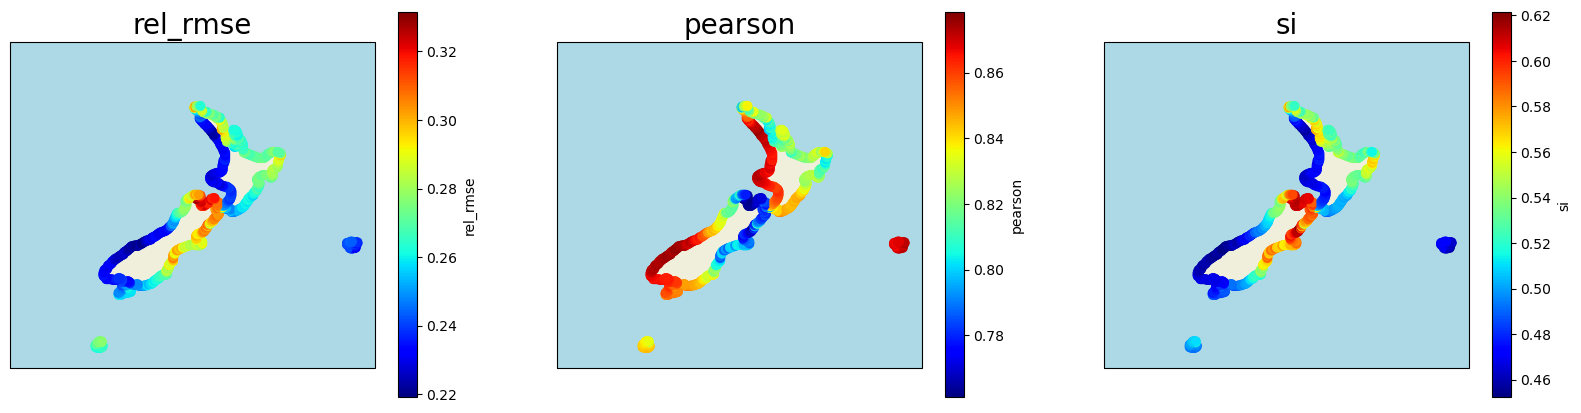

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], load_winds=True, 
    plot=False, time_resample='1D', location=None
)

# load the moana v2 hindcast (more ss and mask)
# ss_grid = (load_moana_hindcast_ss(daily=True) * \
#     xr.open_dataarray('../data/bathymetry/nz_300m_elev_mask.nc'))\
#     .dropna(dim='lon',how='all').dropna(dim='lat',how='all')
# ss_moanav2_site = xr.Dataset(
#     {
#         'ss': (('time','site'), ss_grid.values.reshape(
#             -1,len(ss_grid.lon)*len(ss_grid.lat))),
#         'lon': (('site'), list(ss_grid.lon.values)*int(
#             (len(ss_grid.lon)*len(ss_grid.lat))/len(ss_grid.lon))),
#         'lat': (('site'), np.repeat(ss_grid.lat.values,
#             (len(ss_grid.lon)*len(ss_grid.lat))/len(ss_grid.lat)))
#     }, coords={
#         'site': np.arange(len(ss_grid.lon)*len(ss_grid.lat)),
#         'time': ss_grid.time.values
#     }
# ).dropna(dim='site',how='all')
# plot results

lm_stats = True
if lm_stats:
    stats_local = xr.open_dataset(
        '../data/statistics/models/stats_lm_local_daily.nc'
    )
    plot_stats(stats_local,plot_stats=['rel_rmse','pearson','si'])

## Create the MDA+RBF model

In the cell below, we create the instance of the class `MDA_RBF_Model`, that is located at `sscode/mda_rbf.py`, and shown below:

```python
    class MDA_RBF_Model(object):
        """
        This MDA+RBF model allows the user to perform a model which consists in
        reconstructing / interpolating the storm surge in different locations or
        shores around New Zealand.

        Two options are available for the reconstruction of the SS:

            - First, the storm surge might be directly reconstructed in some
            desired locations (this is what we will be doing to compare with
            the results obtained in the linear and knn models)

            - Moreover, we add here an extra option which consists in giving
            the MDA+RBF interpolating machine the pcs extracted from the ss in 
            several locations from a desired shore. In this case, we will use
            the slp fields pcs to interpolate the non-linear surface of these
            ss-pcs, and then we will reconstruct the real ss in all the locations

        """

        def __init__(self, ss_data, # this should be the loaded moana with Loader class
            slp_data, # this will be used to calculate the local predictors
            dict_to_pca, # this is the parameters dictionary to calculate pca from the slp
            model_metrics=default_evaluation_metrics, # model metrics to evaluate performance
            ss_data_attrs: tuple = ('lon','lat','site','ss'), # ss attrs
            sites_to_analyze = None, # sites to analyze in case individual analysis is performed
            # lons / lats in case shore analysis is required
            lons=[171.2, 169.4, 167.0,  # west-south coast
                  168.1, 167.8,         # south-south
                  166.0,                # south island
                  170.3, 171.6, 173.5,  # east-south
                  173.4, 174.5, 175.1,  # middle bays
                  176.4, 177.5, 178.5,  # east-north
                  176.6, 175.5, 173.7,  # north-north
                  172.8, 173.9, 174.9,  # west-north
                  183.5                 # east island
            ],
            lats=[-41.5, -43.3, -44.8, 
                  -46.0, -47.1, 
                  -50.8,
                  -46.0, -44.1, -42.8, 
                  -40.9, -39.9, -41.2,
                  -41.1, -39.1, -37.4, 
                  -37.8, -35.8, -34.5, 
                  -35.6, -36.8, -38.3,
                  -43.9
            ],
            min_dist_th=[110,100,100,
                         100,60,
                         110,
                         100,100,100,
                         90,90,90,
                         120,120,130,
                         100,120,110,
                         100,80,100,
                         110
            ],
            extra_help=[ # this helps to stay in the wanted shore of NZ
                ('lat',0.9),('lat',0.9),('lat',0.9),
                ('lat',0.7),('lat',0.5),
                ('lon',0.5),
                ('lat',0.8),('lat',0.8),('lat',0.7),
                ('lat',0.3),('lat',0.5),('lon',0.5),
                ('lon',0.3),('lat',0.5),('lon',0.8),
                ('lon',0.7),('lon',0.5),('lat',0.5),
                ('lon',0.8),('lon',0.8),('lat',0.8),
                ('lon',0.5)
            ], # be careful when playing with this tool
            time_resample: str = '1D',
            verbose: bool = True, plot: bool = True):

            """
            As always, we have the initializator/constructor function, where the 
            instance of the class is created, giving some initial parameters

            Args:
                ss_data (xarray.Dataset): This is the previously loaded moana dataset.
                    This might be just the shore moana dataset or the one including
                    the continental platform until 300m of depth, which is now saved
                    in data/storm_surge_data/moana_hindcast_v2/moana_ss_300m_daily.nc
                slp_data (xarray.Dataset): This is the slp data, also loaded with the
                    usually used, Loader class in data.py
                dict_to_pca (dict): This is the parameters dictionary with all the
                    requested information to calculate the slp principal components      
                model_metrics (list): This is a list with all the model metrics to 
                    evaluate model performance          
                ss_data_attrs (tuple): This is a tuple with the main info regarding
                    the ss data, for posterior calculations
                sites_to_analyze (list): This is the list with all the individual sites
                    where the MDA+RBF technique will be performed
                lons (list): Longitudes of the "middle" location of the shores
                lats (list): Latitudes of the "middle" location of the shores
                min_dist_th (list): Distances in km to find the nearest points to
                    the lons/lats specified
                extra_help (list): This is extra information, regarding the "dimension"
                    in which the shore is projected, so fake nodes are not introduced
                    in the pcs analysis
                time_resample (str, optional): As usually, time resample step

            ***** OPTIONS ARE:
                - Give the desired sites_to_analyze!!
                - Give lon/lat locations and extra_help/min_dist_th for 
                    shore analysis!!

            """
```

where this is the aspect of the initializator, and all the methods of the class and additional funtions must be consulted in the python script!!


 Initializing the MDA + RBF constructor... 


 with longitudes = [171.2, 169.4, 167.0, 168.1, 167.8, 166.0, 170.3, 171.6, 173.5, 173.4, 174.5, 175.1, 176.4, 177.5, 178.2, 176.6, 175.5, 173.7, 172.8, 173.9, 174.9, 183.5] 
 
 and 
 
 latitudes = [-41.5, -43.3, -44.8, -46.0, -47.1, -50.8, -46.0, -44.1, -42.8, -40.9, -39.9, -41.2, -41.1, -39.1, -37.4, -37.8, -35.8, -34.5, -35.6, -36.8, -38.3, -43.9] !!                 

 for the specified middle locations / shores !!

 lets calculate the storm surge pcs... 


 All the SS pcs have been calculated, lets plot what we got!! 



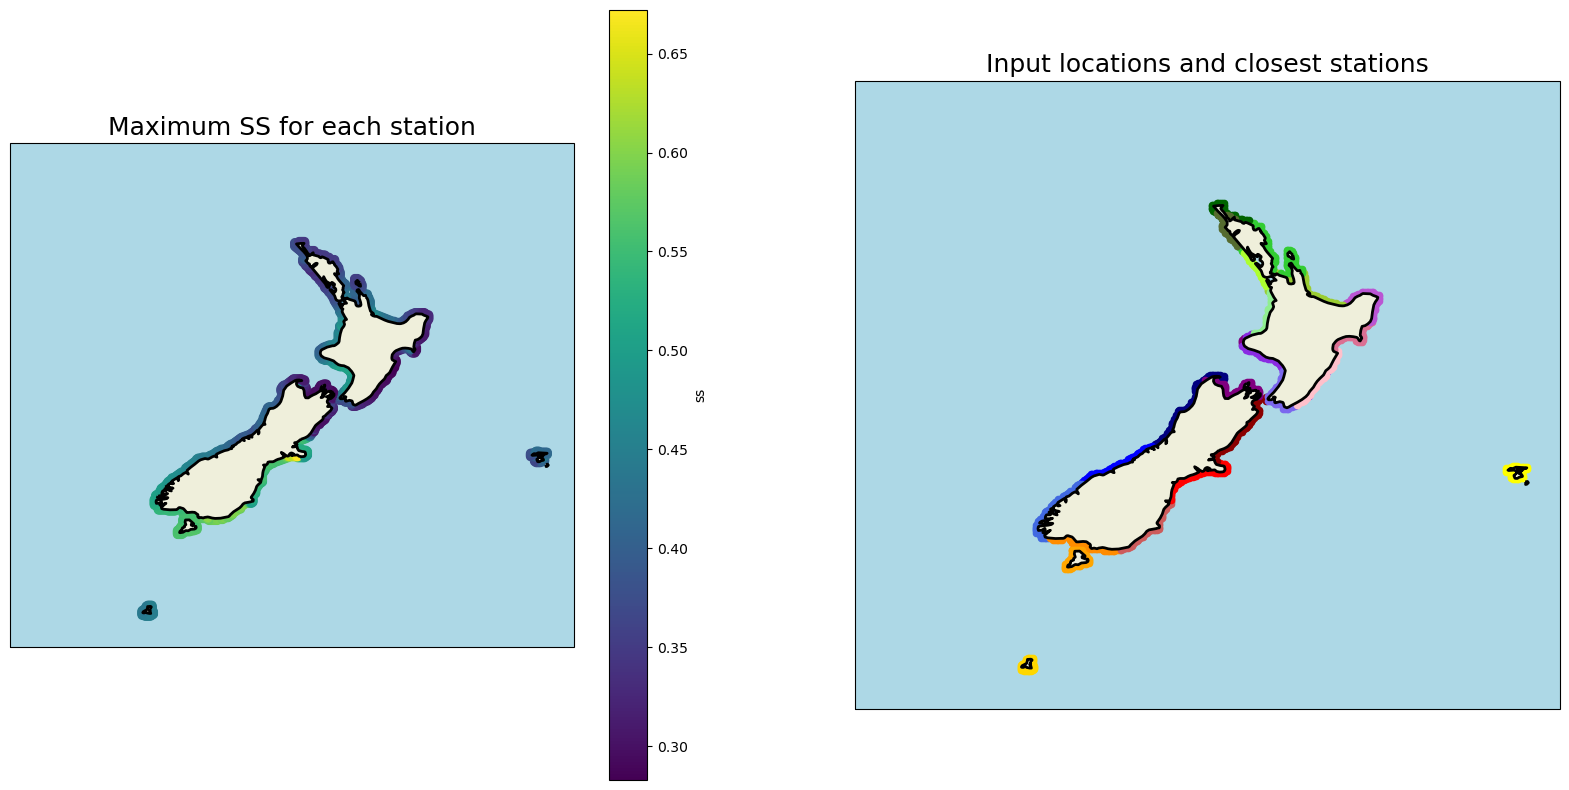


 data will be resampled to 1D 

 and the PC analysis             will be calculated using the parameters 

 {'pres_vars': ('SLP', 'longitude', 'latitude'), 'calculate_gradient': True, 'winds': (True, <xarray.Dataset>
Dimensions:          (lat: 160, lon: 161, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat              (lat) float32 -20.14 -20.45 -20.76 ... -69.16 -69.47 -69.78
  * lon              (lon) float32 140.0 140.3 140.6 140.9 ... 189.4 189.7 190.0
Data variables:
    U_GRD_L103       (time, lat, lon) float32 ...
    V_GRD_L103       (time, lat, lon) float32 ...
    wind_proj        (time, lat, lon) float64 ...
    bearings         (lat, lon) float64 ...
    direc_proj_math  (lat, lon) float64 ...
    wind_proj_mask   (time, lat, lon) float64 ...), 'wind_vars': ('wind_proj_mask', 'lon', 'lat'), 'time_lapse': 3, 'time_resample': '1D', 'region': ('local', (2.5, 2.5)), 'pca_plot': (True, False, 1), 'verbose': True,

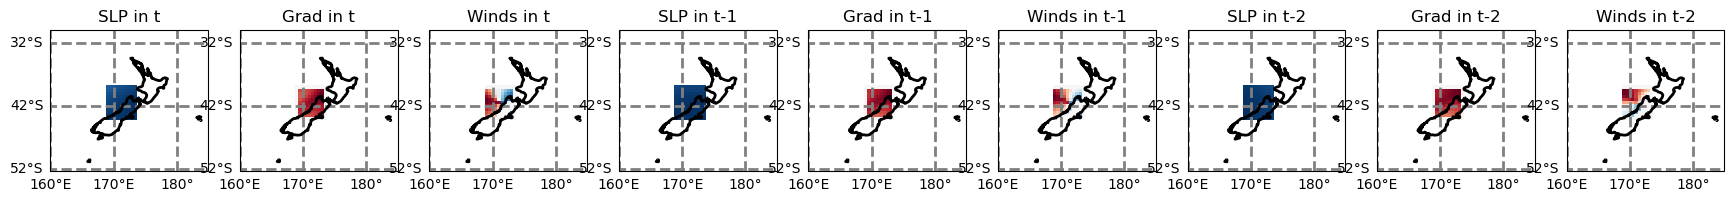

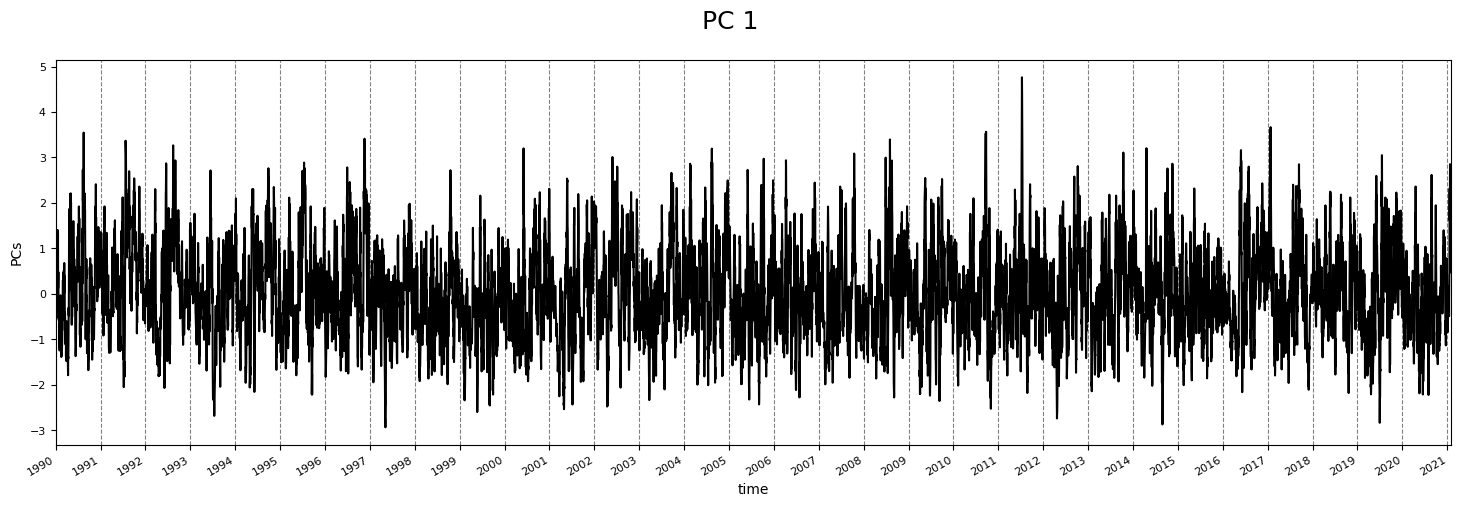

pcs matrix calculation for site / shore 2
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -41.06 -41.37 -41.68 ... -45.12 -45.43 -45.74
  * lon             (lon) float32 167.2 167.5 167.8 168.1 ... 171.2 171.6 171.9
Data variables:
    U_GRD_L103      (time, lat, lon) float32 1.693 1.321 1.088 ... 4.783 5.384
    V_GRD_L103      (time, lat, lon) float32 -3.327 -2.986 -2.64 ... 3.384 4.056
    uw2             (time, lat, lon) float32 2.866 1.745 1.184 ... 22.88 28.99
    vw2             (time, lat, lon) float32 11.07 8.916 6.971 ... 11.45 16.45
    wind_magnitude  (time, lat, lon) float32 3.733 3.265 2.856 ... 5.859 6.741 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns

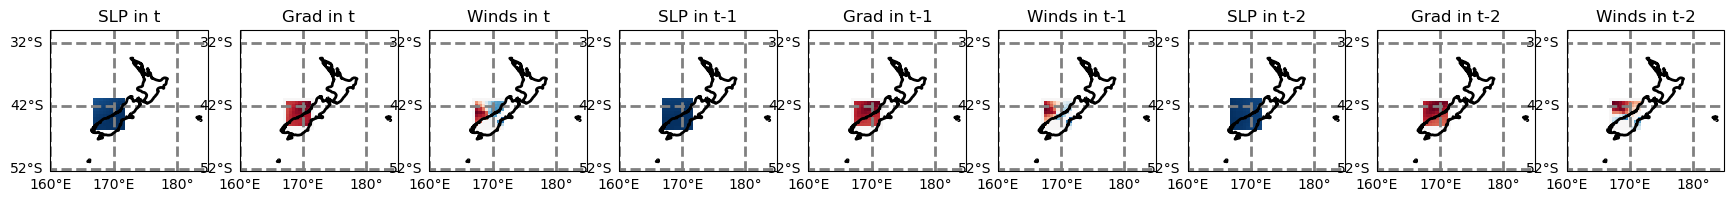

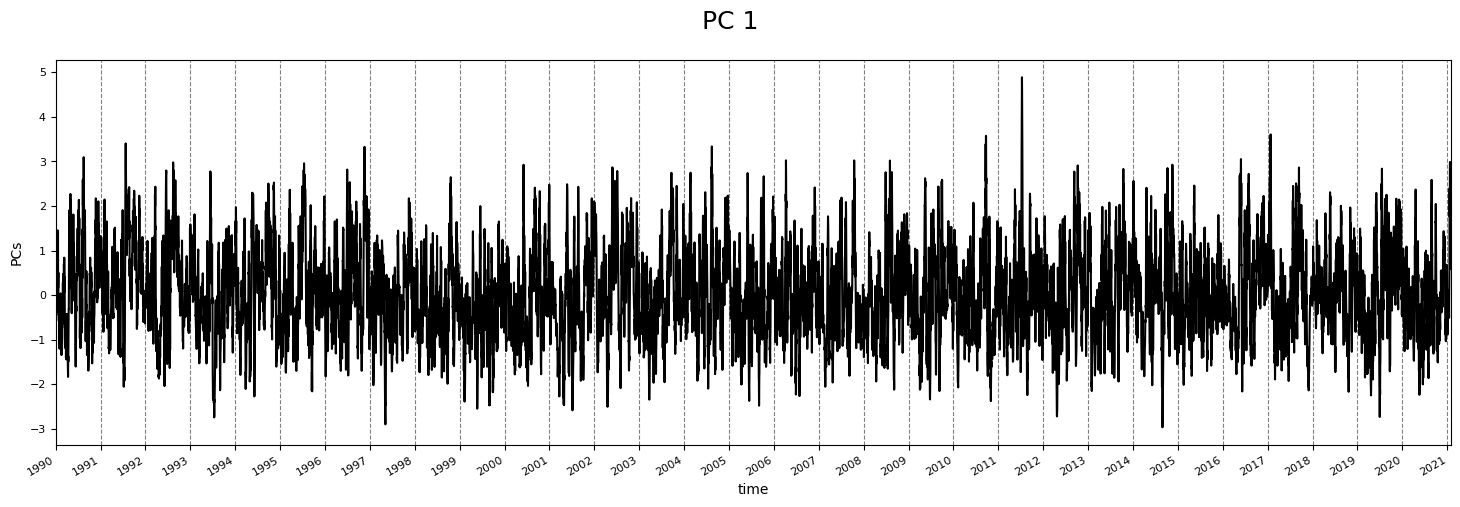

pcs matrix calculation for site / shore 3
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -42.31 -42.62 -42.93 ... -46.37 -46.68 -46.99
  * lon             (lon) float32 164.7 165.0 165.3 165.6 ... 168.8 169.1 169.4
Data variables:
    U_GRD_L103      (time, lat, lon) float32 4.068 3.808 3.564 ... 8.914 9.434
    V_GRD_L103      (time, lat, lon) float32 -5.29 -5.286 ... -3.873 -3.075
    uw2             (time, lat, lon) float32 16.55 14.5 12.71 ... 79.47 89.0
    vw2             (time, lat, lon) float32 27.98 27.94 27.06 ... 15.0 9.455
    wind_magnitude  (time, lat, lon) float32 6.673 6.515 6.306 ... 9.72 9.922 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990-01

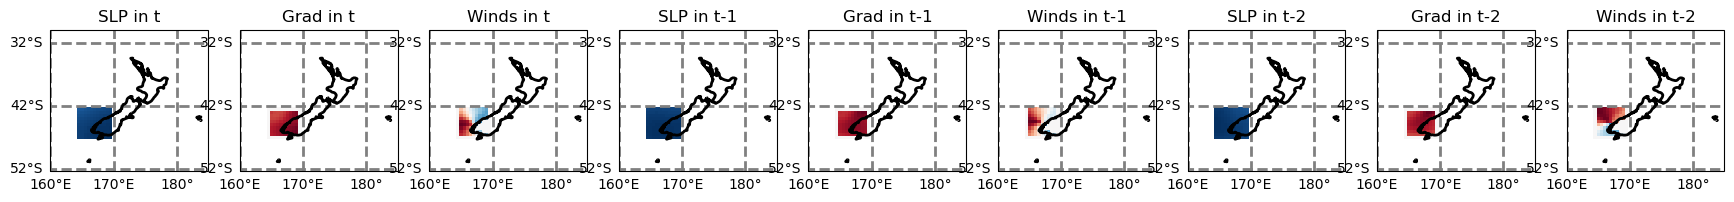

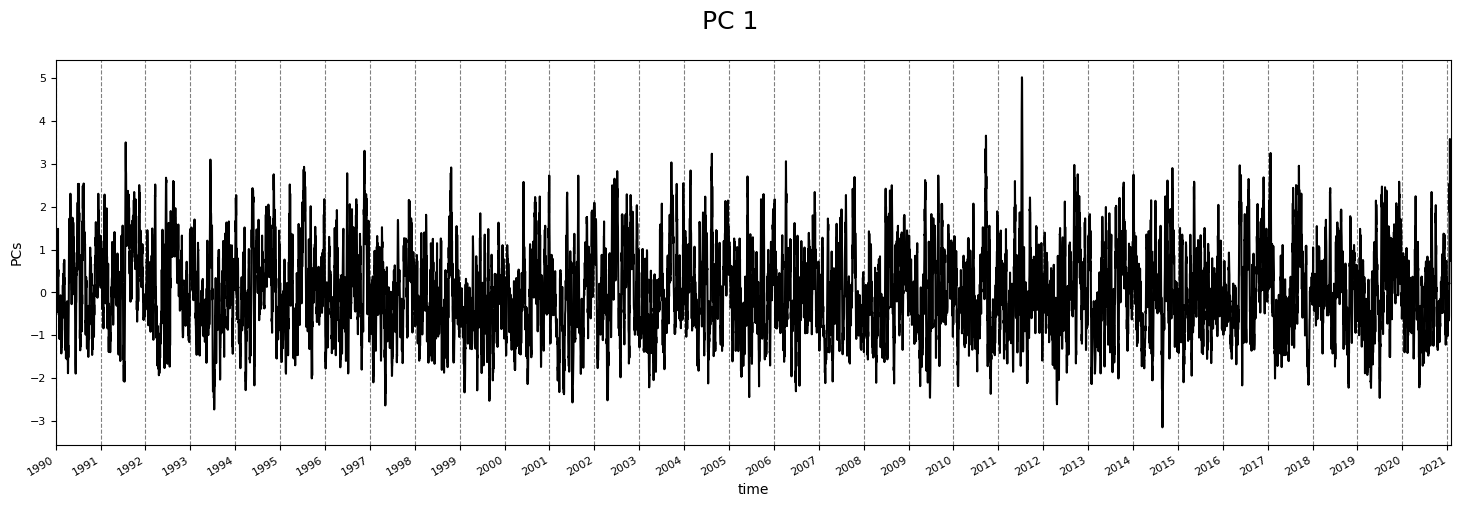

pcs matrix calculation for site / shore 4
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -43.56 -43.87 -44.18 ... -47.61 -47.93 -48.24
  * lon             (lon) float32 165.6 165.9 166.2 166.6 ... 169.7 170.0 170.3
Data variables:
    U_GRD_L103      (time, lat, lon) float32 2.961 2.788 2.6 ... 10.25 10.4
    V_GRD_L103      (time, lat, lon) float32 -6.897 -6.821 ... -2.056 -1.73
    uw2             (time, lat, lon) float32 8.765 7.772 6.762 ... 105.1 108.1
    vw2             (time, lat, lon) float32 47.57 46.53 44.32 ... 4.227 2.991
    wind_magnitude  (time, lat, lon) float32 7.506 7.369 7.147 ... 10.46 10.54 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990-0

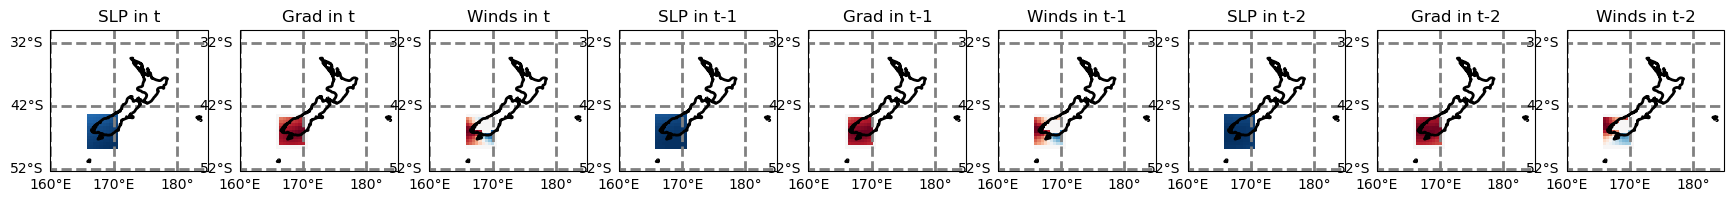

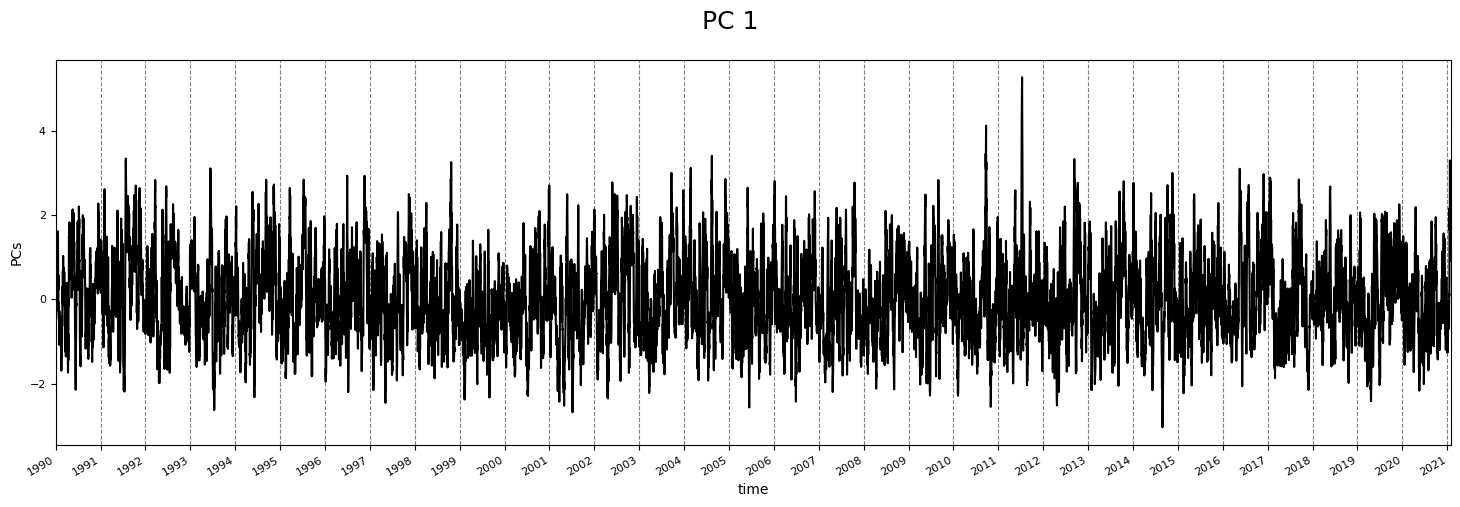

pcs matrix calculation for site / shore 5
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -44.8 -45.12 -45.43 ... -48.86 -49.18 -49.49
  * lon             (lon) float32 165.3 165.6 165.9 166.2 ... 169.4 169.7 170.0
Data variables:
    U_GRD_L103      (time, lat, lon) float32 2.132 1.574 0.9347 ... 12.63 12.73
    V_GRD_L103      (time, lat, lon) float32 -8.22 -8.466 ... -3.488 -3.231
    uw2             (time, lat, lon) float32 4.545 2.478 0.8738 ... 159.6 162.1
    vw2             (time, lat, lon) float32 67.57 71.67 74.95 ... 12.17 10.44
    wind_magnitude  (time, lat, lon) float32 8.492 8.611 8.708 ... 13.11 13.14 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 19

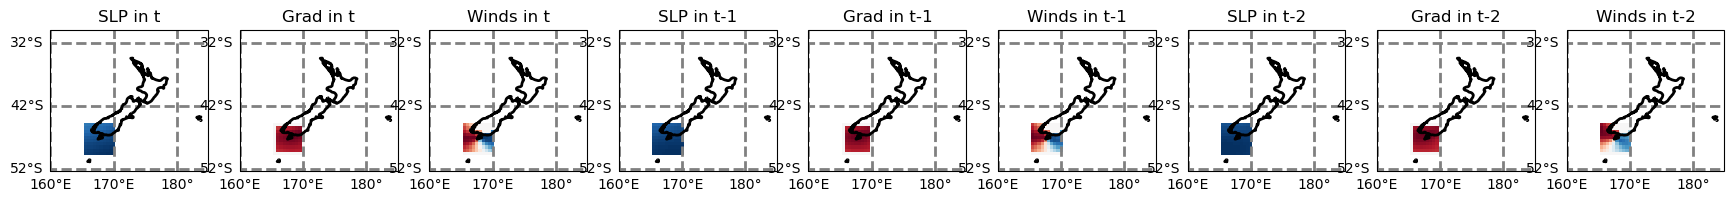

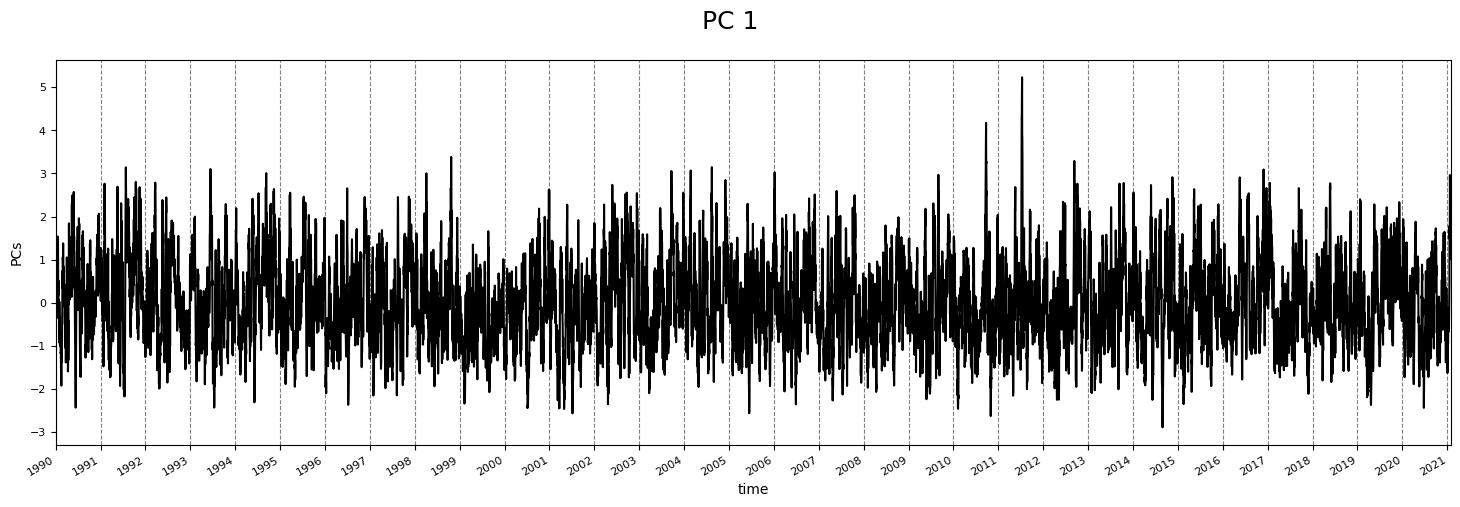

pcs matrix calculation for site / shore 6
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -48.55 -48.86 -49.18 ... -52.61 -52.92 -53.24
  * lon             (lon) float32 163.8 164.1 164.4 164.7 ... 167.8 168.1 168.4
Data variables:
    U_GRD_L103      (time, lat, lon) float32 2.292 2.259 2.181 ... 16.88 16.9
    V_GRD_L103      (time, lat, lon) float32 -8.699 -8.536 ... -3.135 -3.261
    uw2             (time, lat, lon) float32 5.252 5.105 4.756 ... 284.8 285.6
    vw2             (time, lat, lon) float32 75.68 72.87 70.43 ... 9.828 10.64
    wind_magnitude  (time, lat, lon) float32 8.996 8.83 8.671 ... 17.16 17.21 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990

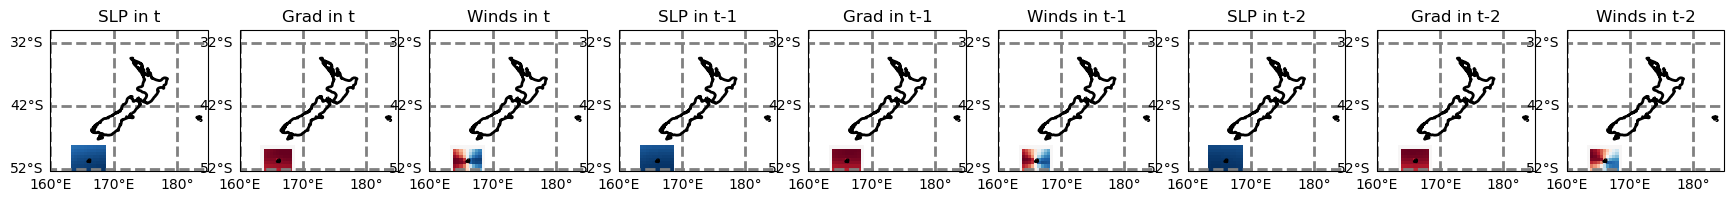

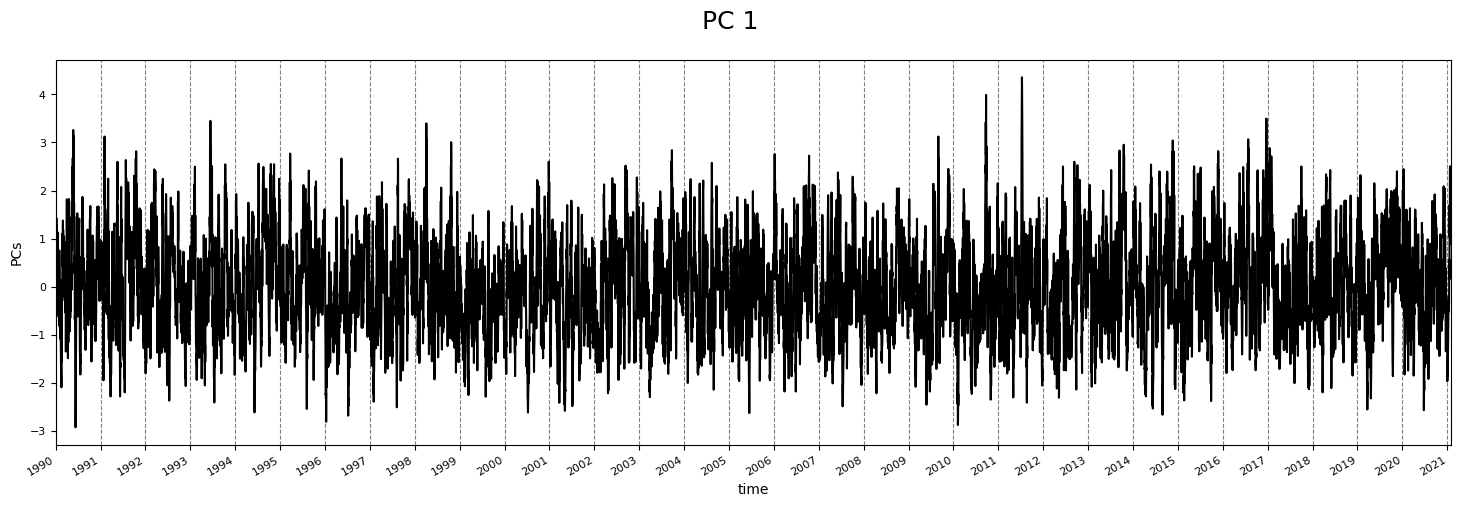

pcs matrix calculation for site / shore 7
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -43.56 -43.87 -44.18 ... -47.61 -47.93 -48.24
  * lon             (lon) float32 167.8 168.1 168.4 168.8 ... 171.9 172.2 172.5
Data variables:
    U_GRD_L103      (time, lat, lon) float32 0.3456 -0.1699 ... 9.819 9.665
    V_GRD_L103      (time, lat, lon) float32 -3.924 -3.163 ... 0.8293 1.188
    uw2             (time, lat, lon) float32 0.1194 0.02887 ... 96.41 93.4
    vw2             (time, lat, lon) float32 15.4 10.01 7.248 ... 0.6877 1.412
    wind_magnitude  (time, lat, lon) float32 3.939 3.168 2.732 ... 9.854 9.737 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990-01-01

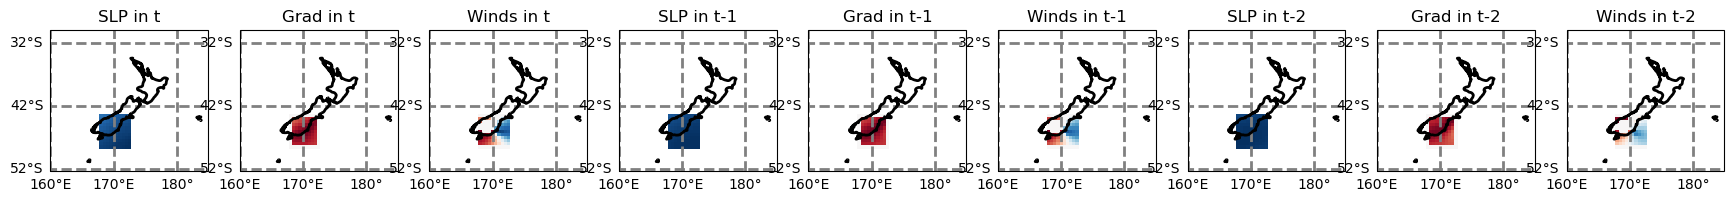

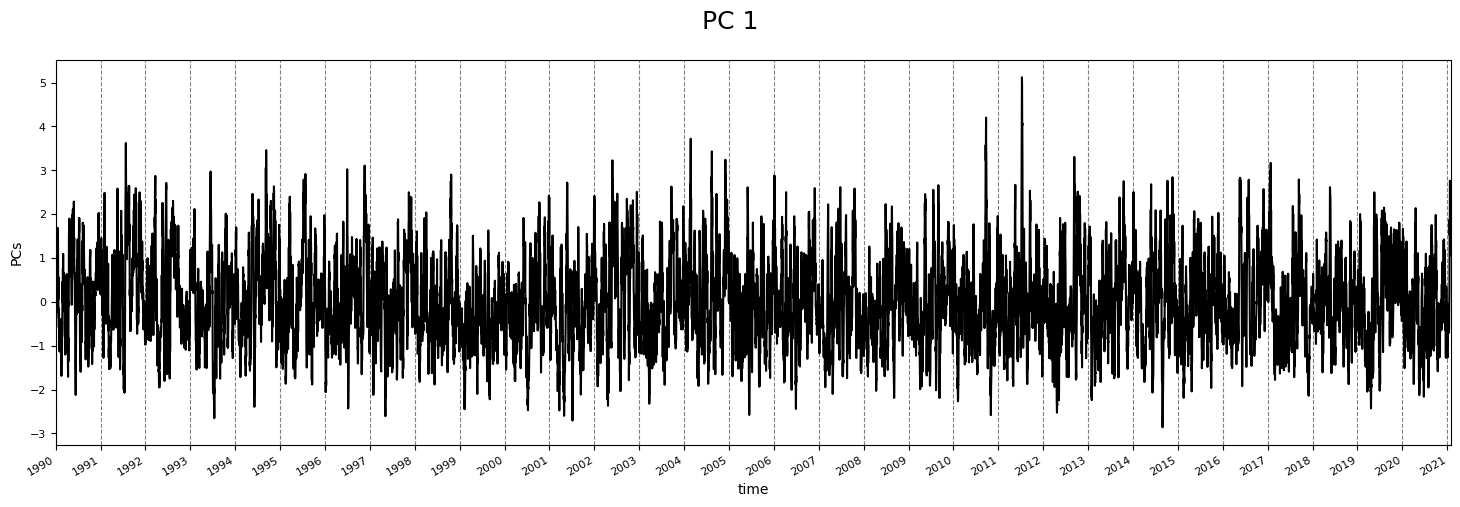

pcs matrix calculation for site / shore 8
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -41.68 -41.99 -42.31 ... -45.74 -46.05 -46.37
  * lon             (lon) float32 169.4 169.7 170.0 170.3 ... 173.4 173.8 174.1
Data variables:
    U_GRD_L103      (time, lat, lon) float32 1.893 1.903 1.925 ... 7.641 7.327
    V_GRD_L103      (time, lat, lon) float32 -1.44 -1.163 ... 4.217 4.057
    uw2             (time, lat, lon) float32 3.582 3.621 3.706 ... 58.39 53.68
    vw2             (time, lat, lon) float32 2.073 1.352 0.8355 ... 17.78 16.46
    wind_magnitude  (time, lat, lon) float32 2.378 2.23 2.131 ... 8.728 8.375 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990-

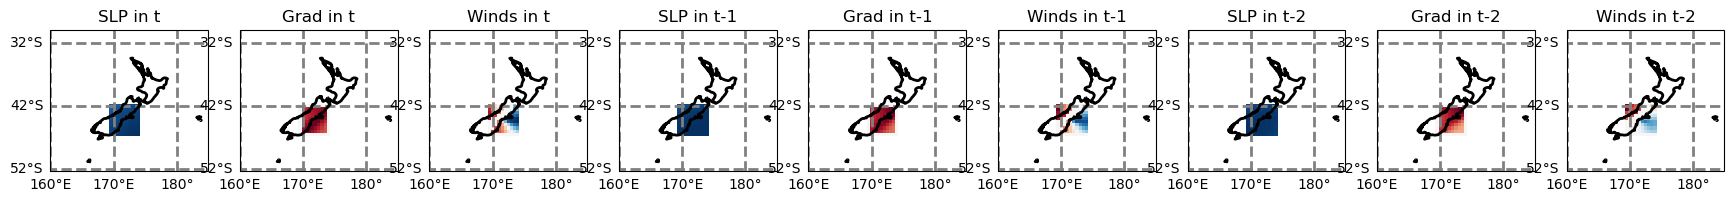

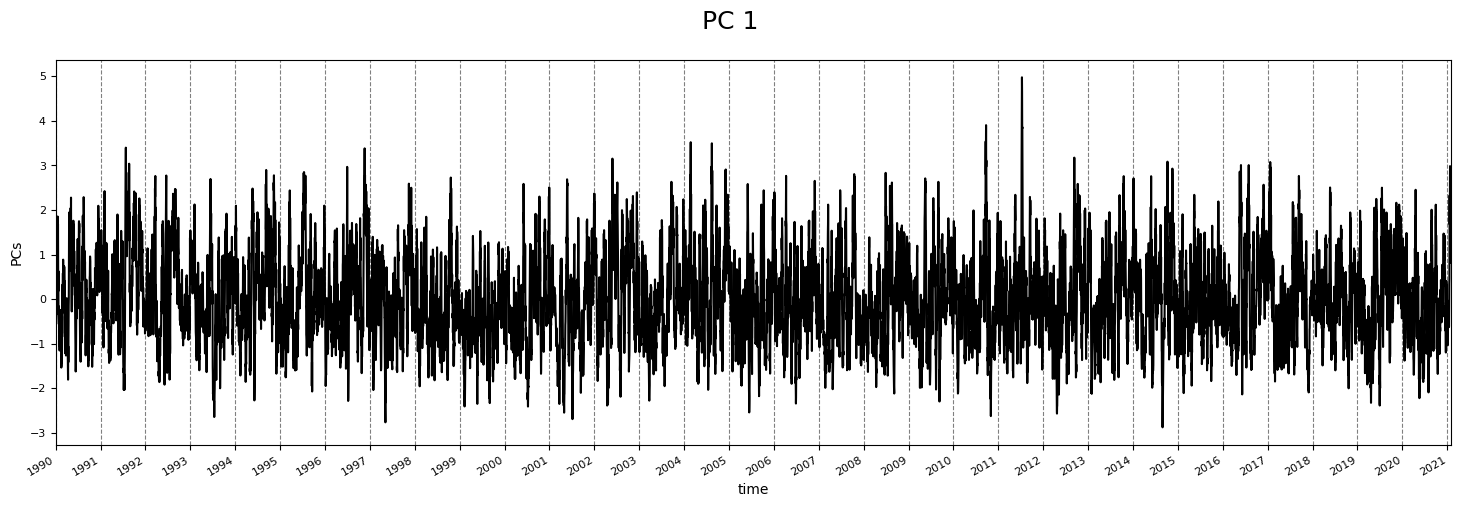

pcs matrix calculation for site / shore 9
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -40.43 -40.75 -41.06 ... -44.49 -44.8 -45.12
  * lon             (lon) float32 171.2 171.6 171.9 172.2 ... 175.3 175.6 175.9
Data variables:
    U_GRD_L103      (time, lat, lon) float32 1.746 2.523 3.411 ... 5.003 5.302
    V_GRD_L103      (time, lat, lon) float32 0.4252 1.109 1.524 ... 6.686 7.093
    uw2             (time, lat, lon) float32 3.048 6.368 11.64 ... 25.03 28.11
    vw2             (time, lat, lon) float32 0.1808 1.231 2.323 ... 44.71 50.31
    wind_magnitude  (time, lat, lon) float32 1.797 2.756 3.736 ... 8.351 8.855 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns]

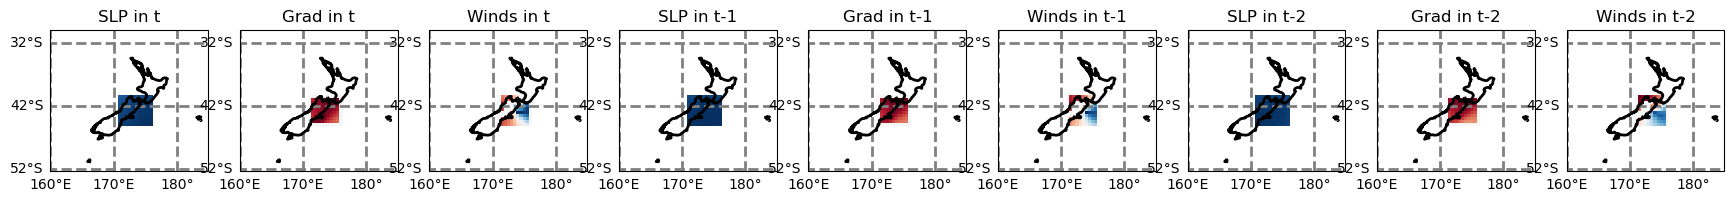

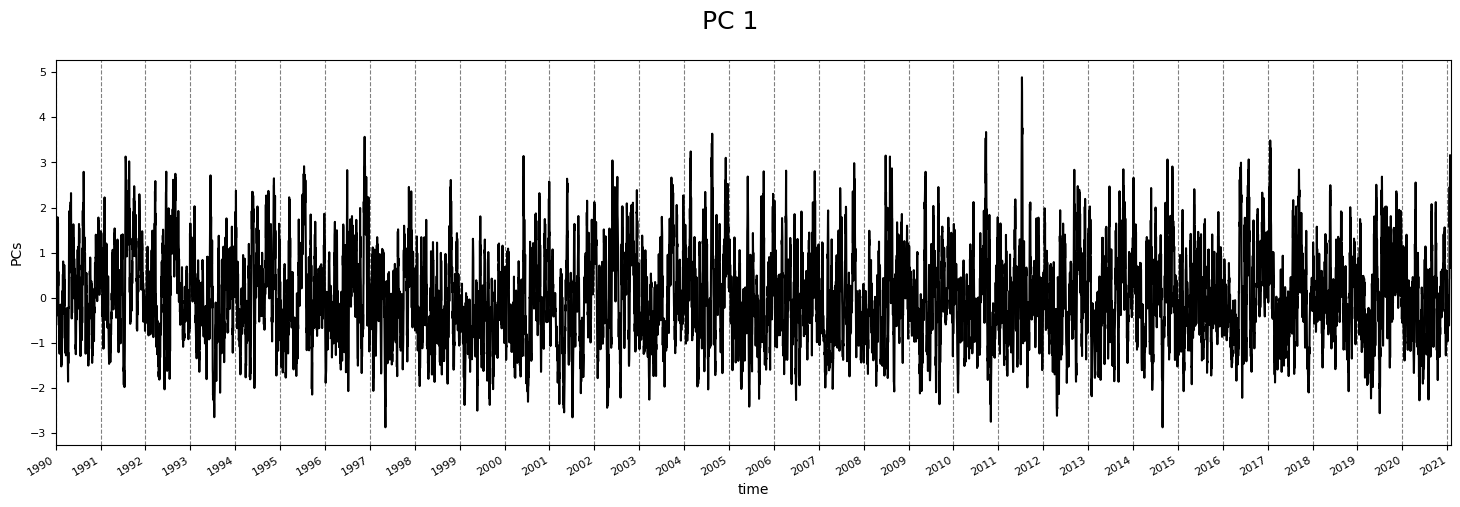

pcs matrix calculation for site / shore 10
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -38.56 -38.87 -39.18 ... -42.62 -42.93 -43.24
  * lon             (lon) float32 170.9 171.2 171.6 171.9 ... 175.0 175.3 175.6
Data variables:
    U_GRD_L103      (time, lat, lon) float32 0.2336 -0.2325 ... 6.479 5.66
    V_GRD_L103      (time, lat, lon) float32 -0.1597 -0.03608 ... 7.222 7.336
    uw2             (time, lat, lon) float32 0.05456 0.05406 ... 41.97 32.04
    vw2             (time, lat, lon) float32 0.02549 0.001302 ... 52.16 53.81
    wind_magnitude  (time, lat, lon) float32 0.2829 0.2353 ... 9.702 9.266 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990-01-01 

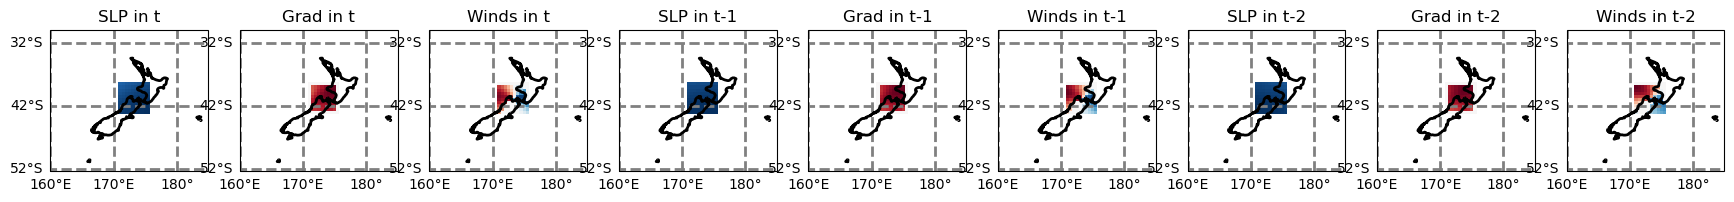

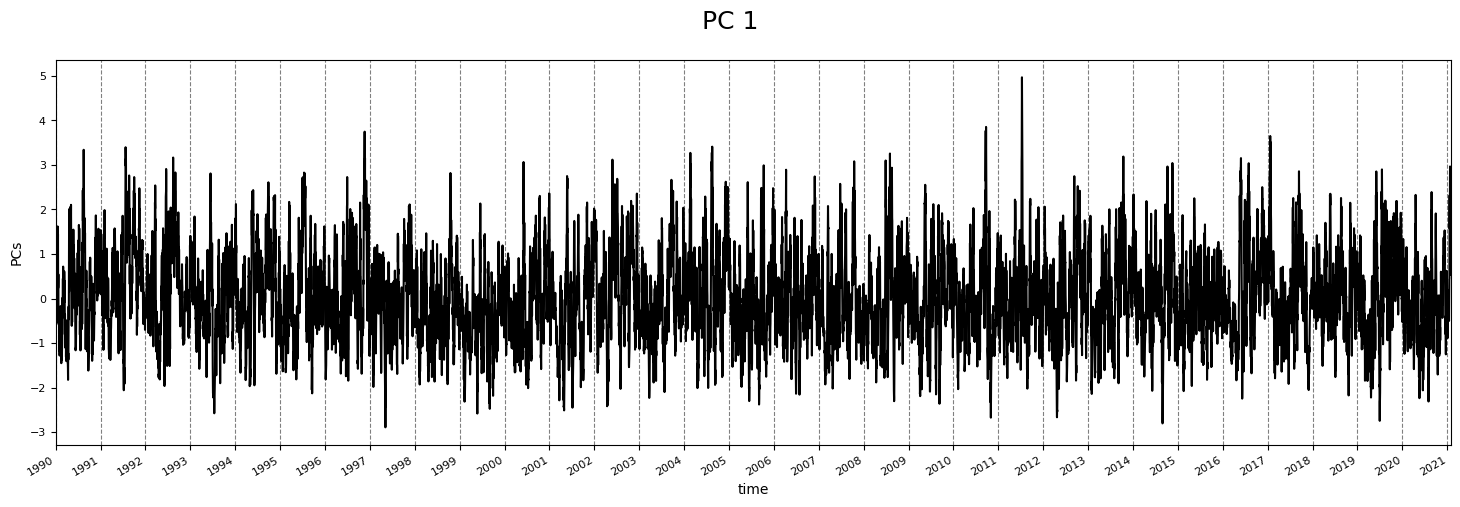

pcs matrix calculation for site / shore 11
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -37.62 -37.94 -38.25 ... -41.68 -41.99 -42.31
  * lon             (lon) float32 172.2 172.5 172.8 173.1 ... 176.2 176.6 176.9
Data variables:
    U_GRD_L103      (time, lat, lon) float32 -2.392 -2.465 ... 5.496 5.625
    V_GRD_L103      (time, lat, lon) float32 2.365 2.868 3.313 ... 8.674 9.038
    uw2             (time, lat, lon) float32 5.722 6.078 5.632 ... 30.2 31.64
    vw2             (time, lat, lon) float32 5.591 8.223 10.97 ... 75.24 81.69
    wind_magnitude  (time, lat, lon) float32 3.363 3.782 4.075 ... 10.27 10.65 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990

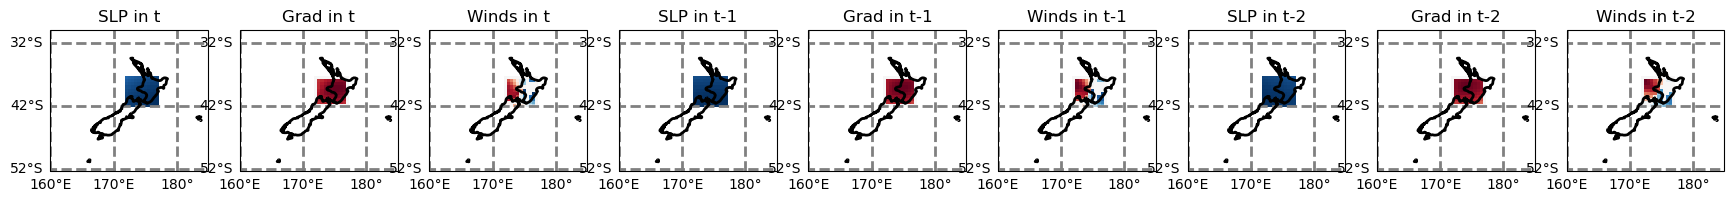

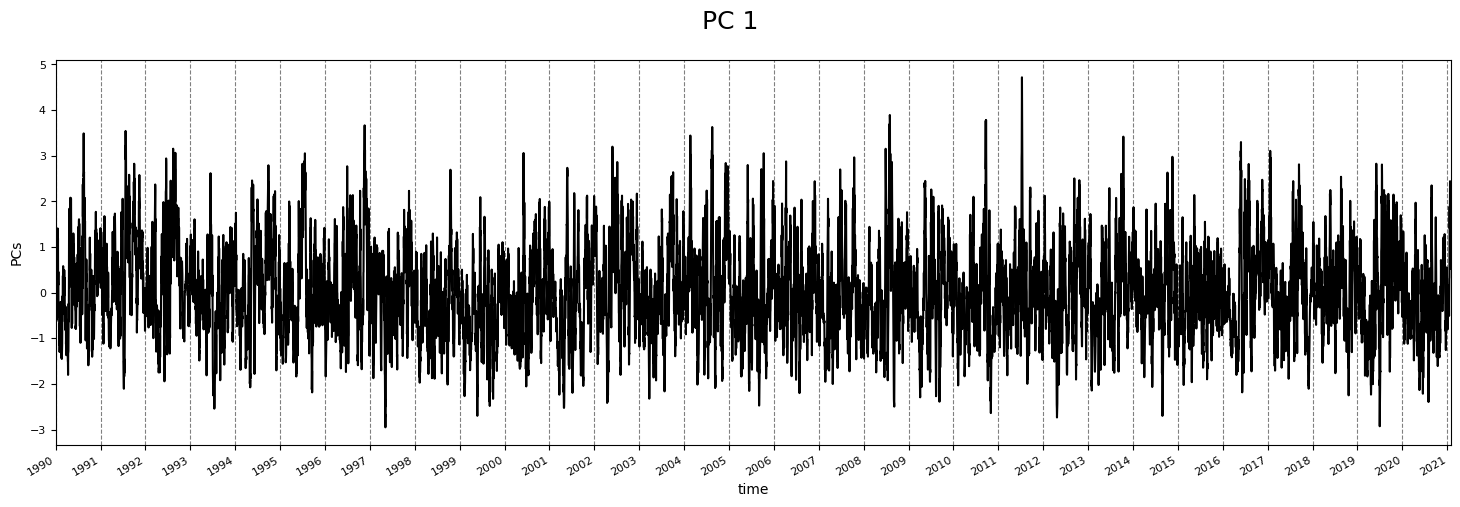

pcs matrix calculation for site / shore 12
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -38.87 -39.18 -39.5 ... -42.93 -43.24 -43.56
  * lon             (lon) float32 172.8 173.1 173.4 173.8 ... 176.9 177.2 177.5
Data variables:
    U_GRD_L103      (time, lat, lon) float32 0.4146 0.8391 1.223 ... 4.195 3.632
    V_GRD_L103      (time, lat, lon) float32 2.775 3.266 3.386 ... 9.593 9.722
    uw2             (time, lat, lon) float32 0.1719 0.7041 1.495 ... 17.6 13.19
    vw2             (time, lat, lon) float32 7.702 10.67 11.46 ... 92.02 94.51
    wind_magnitude  (time, lat, lon) float32 2.806 3.372 3.6 ... 10.47 10.38 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns]

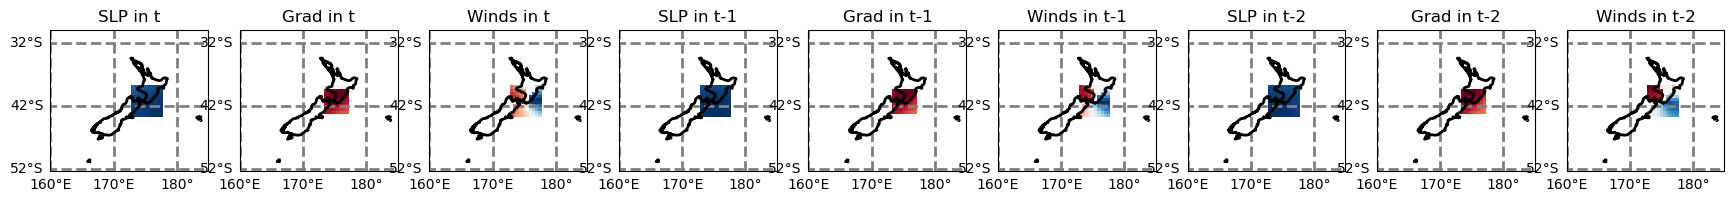

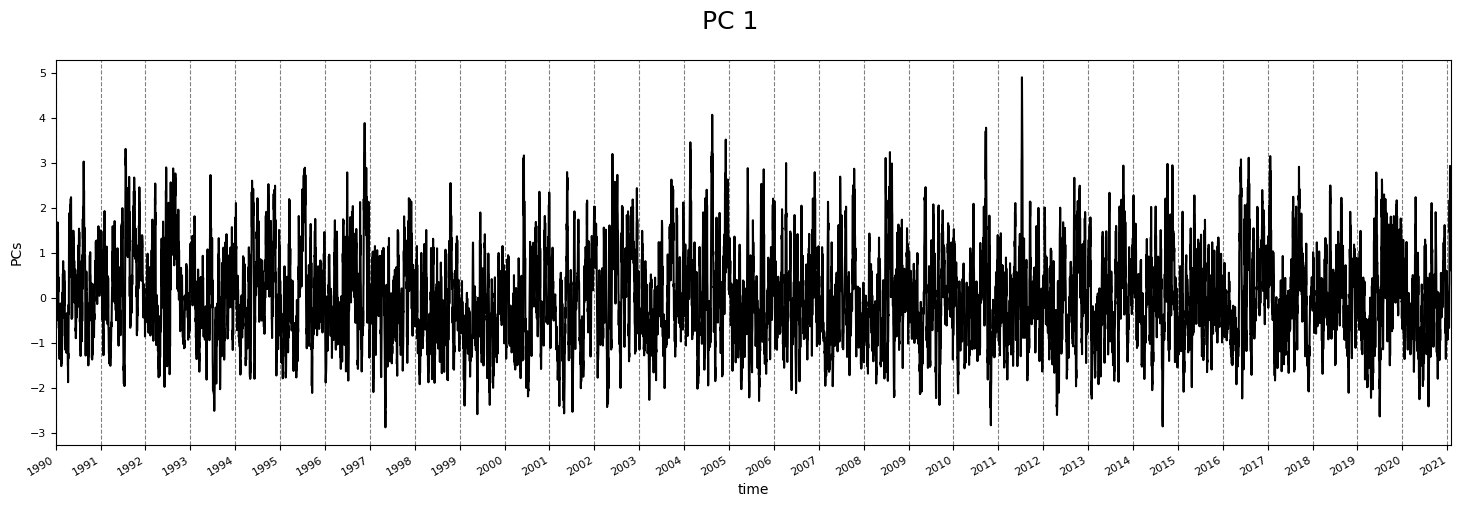

pcs matrix calculation for site / shore 13
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -38.87 -39.18 -39.5 ... -42.93 -43.24 -43.56
  * lon             (lon) float32 174.1 174.4 174.7 175.0 ... 178.1 178.4 178.8
Data variables:
    U_GRD_L103      (time, lat, lon) float32 1.509 1.311 1.088 ... 3.324 4.1
    V_GRD_L103      (time, lat, lon) float32 2.365 1.432 0.4588 ... 10.28 10.55
    uw2             (time, lat, lon) float32 2.277 1.719 1.183 ... 11.05 16.81
    vw2             (time, lat, lon) float32 5.593 2.051 0.2105 ... 105.7 111.3
    wind_magnitude  (time, lat, lon) float32 2.805 1.942 1.18 ... 10.81 11.32 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1

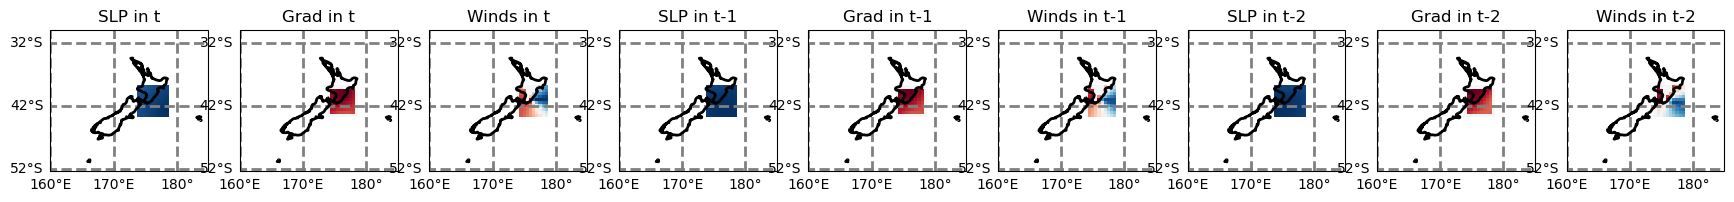

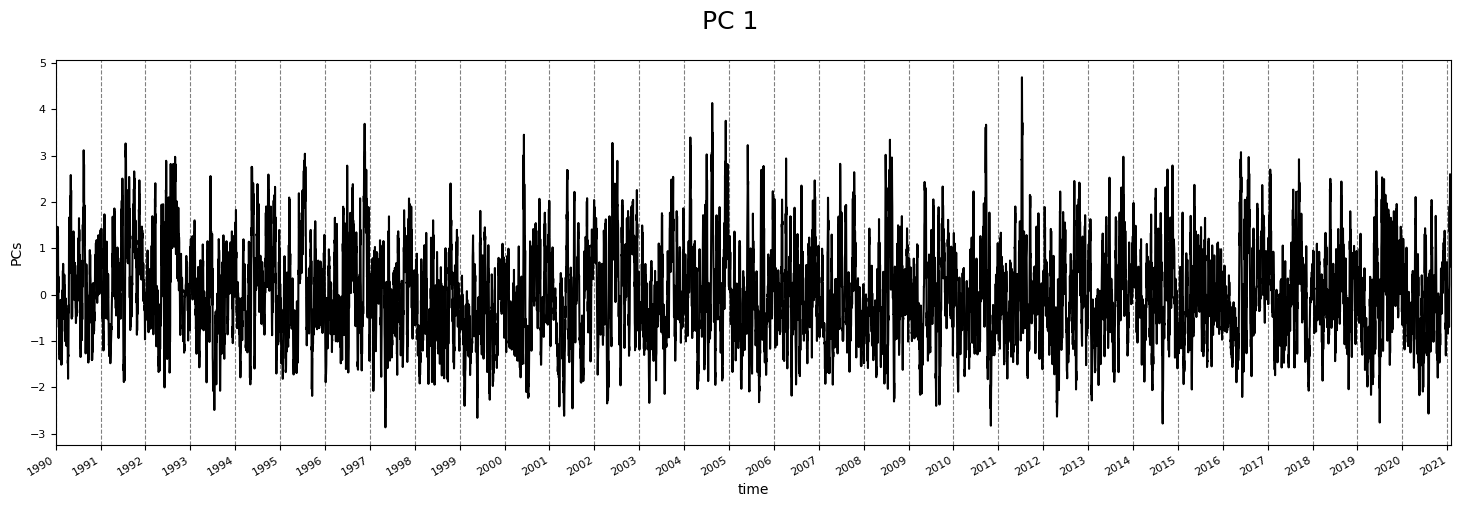

pcs matrix calculation for site / shore 14
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 17, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -36.69 -37.0 -37.31 ... -40.75 -41.06 -41.37
  * lon             (lon) float32 175.0 175.3 175.6 175.9 ... 179.4 179.7 180.0
Data variables:
    U_GRD_L103      (time, lat, lon) float32 -1.346 -1.844 ... 4.834 5.613
    V_GRD_L103      (time, lat, lon) float32 1.152 0.4055 ... 11.74 11.78
    uw2             (time, lat, lon) float32 1.812 3.401 6.755 ... 23.37 31.5
    vw2             (time, lat, lon) float32 1.327 0.1644 0.3117 ... 137.9 138.7
    wind_magnitude  (time, lat, lon) float32 1.772 1.888 2.658 ... 12.7 13.05 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 17, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990-01-0

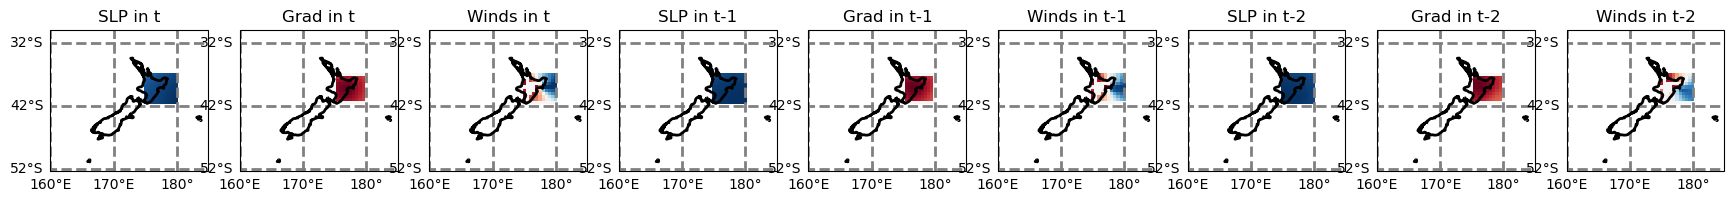

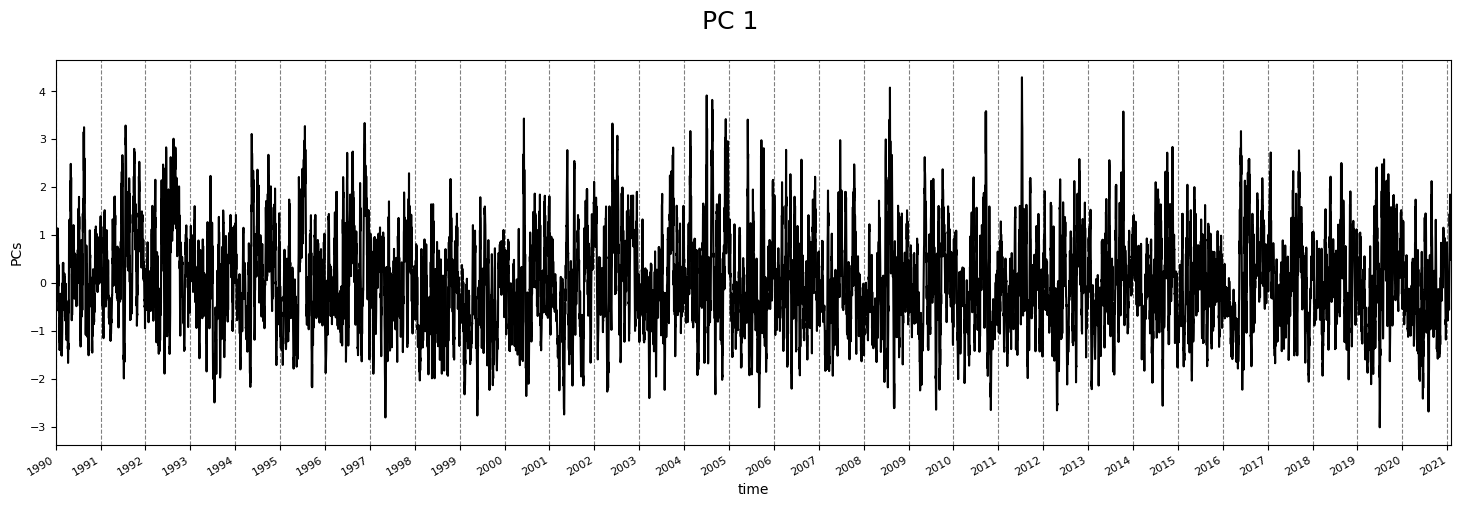

pcs matrix calculation for site / shore 15
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -35.13 -35.44 -35.75 ... -39.18 -39.5 -39.81
  * lon             (lon) float32 175.9 176.2 176.6 176.9 ... 180.0 180.3 180.6
Data variables:
    U_GRD_L103      (time, lat, lon) float32 2.18 2.041 1.479 ... 4.347 4.772
    V_GRD_L103      (time, lat, lon) float32 -1.334 -2.861 ... 12.24 12.23
    uw2             (time, lat, lon) float32 4.754 4.167 2.189 ... 18.9 22.78
    vw2             (time, lat, lon) float32 1.78 8.188 17.52 ... 149.8 149.5
    wind_magnitude  (time, lat, lon) float32 2.556 3.515 4.44 ... 12.99 13.12 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990-01-

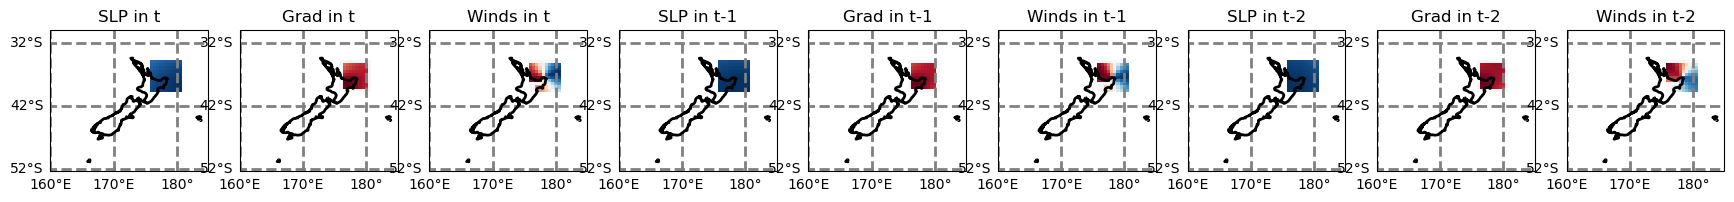

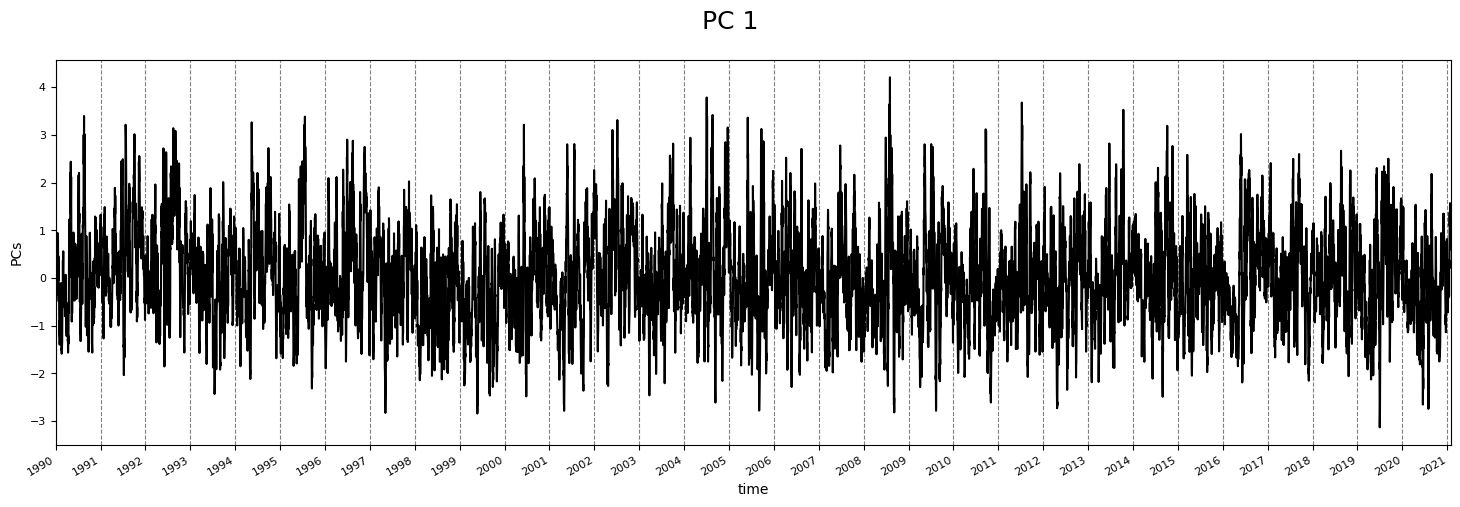

pcs matrix calculation for site / shore 16
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -35.44 -35.75 -36.06 ... -39.5 -39.81 -40.12
  * lon             (lon) float32 174.4 174.7 175.0 175.3 ... 178.4 178.8 179.1
Data variables:
    U_GRD_L103      (time, lat, lon) float32 -0.2312 -0.1434 ... 4.311 4.07
    V_GRD_L103      (time, lat, lon) float32 -0.365 -0.1364 ... 10.83 11.21
    uw2             (time, lat, lon) float32 0.05344 0.02057 ... 18.58 16.56
    vw2             (time, lat, lon) float32 0.1332 0.01861 ... 117.2 125.7
    wind_magnitude  (time, lat, lon) float32 0.432 0.1979 0.3339 ... 11.65 11.93 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990-01-0

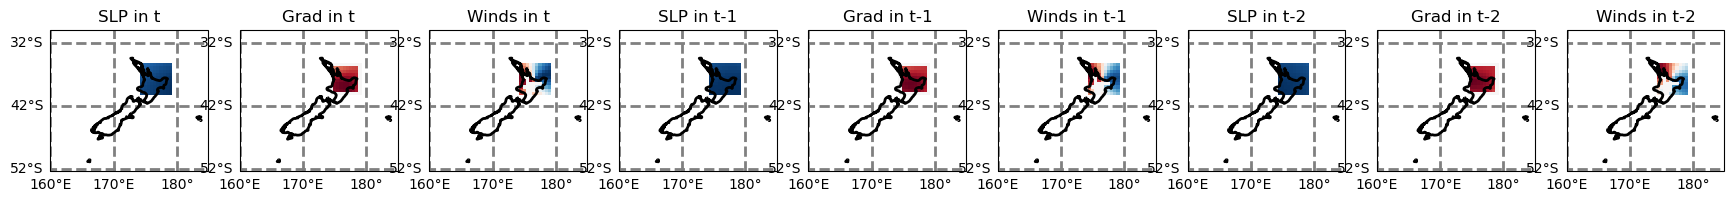

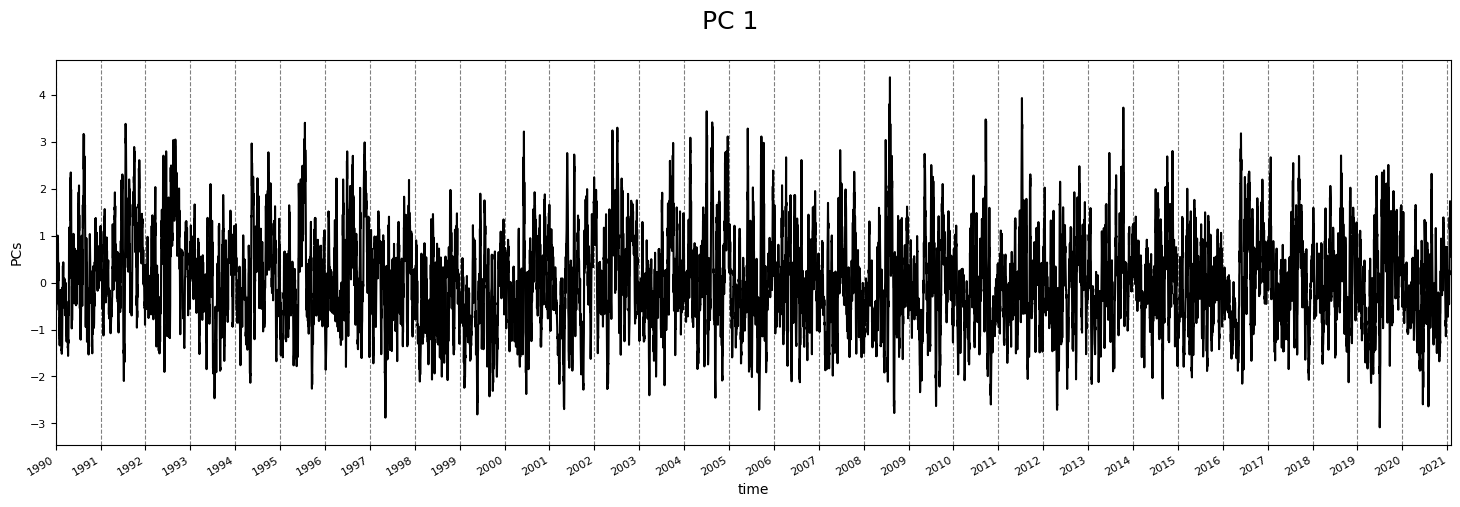

pcs matrix calculation for site / shore 17
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -33.56 -33.88 -34.19 ... -37.62 -37.94 -38.25
  * lon             (lon) float32 173.1 173.4 173.8 174.1 ... 177.2 177.5 177.8
Data variables:
    U_GRD_L103      (time, lat, lon) float32 -3.372 -2.613 ... -1.399 0.1239
    V_GRD_L103      (time, lat, lon) float32 1.599 1.951 2.159 ... 6.196 5.796
    uw2             (time, lat, lon) float32 11.37 6.826 3.104 ... 1.956 0.01535
    vw2             (time, lat, lon) float32 2.558 3.807 4.662 ... 38.39 33.59
    wind_magnitude  (time, lat, lon) float32 3.732 3.261 2.787 ... 6.352 5.797 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns]

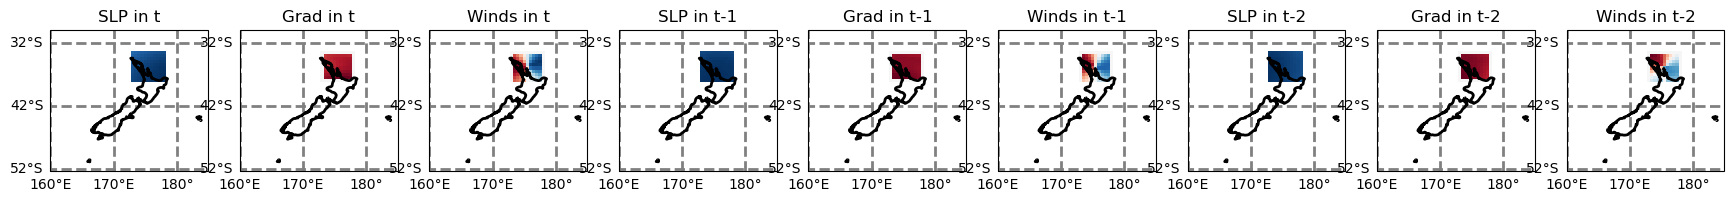

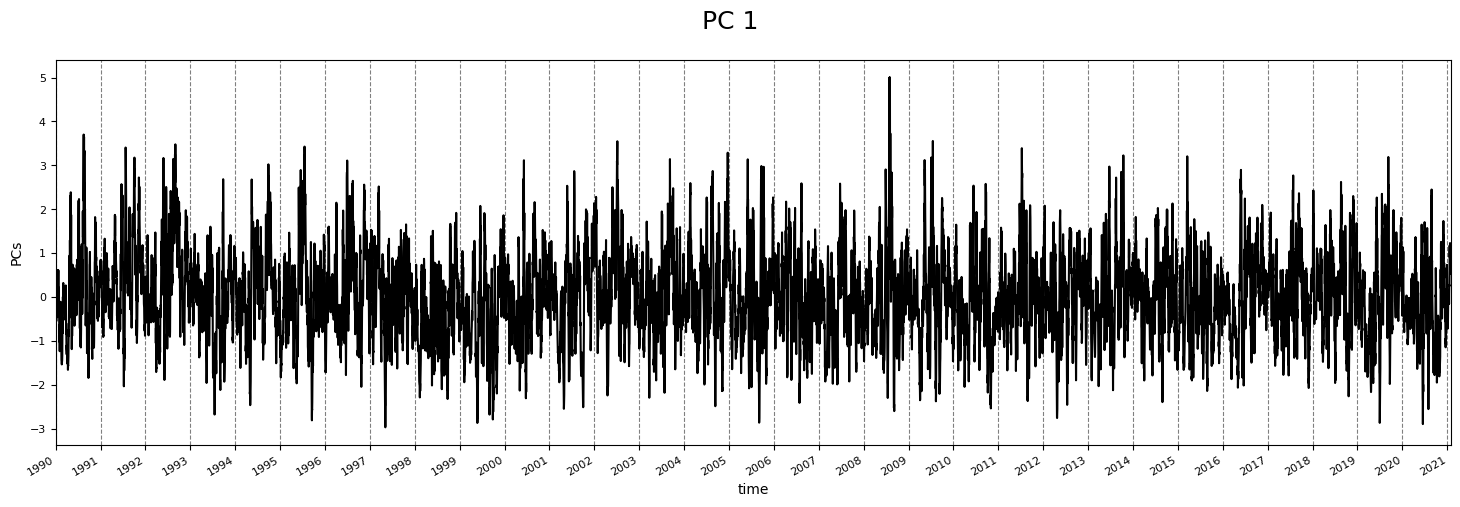

pcs matrix calculation for site / shore 18
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 17, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -32.0 -32.32 -32.63 ... -36.37 -36.69 -37.0
  * lon             (lon) float32 171.2 171.6 171.9 172.2 ... 175.3 175.6 175.9
Data variables:
    U_GRD_L103      (time, lat, lon) float32 -5.961 -5.913 ... -3.756 -4.345
    V_GRD_L103      (time, lat, lon) float32 -1.826 -1.456 ... 3.165 5.172
    uw2             (time, lat, lon) float32 35.53 34.96 33.56 ... 14.11 18.88
    vw2             (time, lat, lon) float32 3.336 2.121 1.234 ... 10.02 26.75
    wind_magnitude  (time, lat, lon) float32 6.234 6.09 5.899 ... 4.912 6.755 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 17, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990-01-

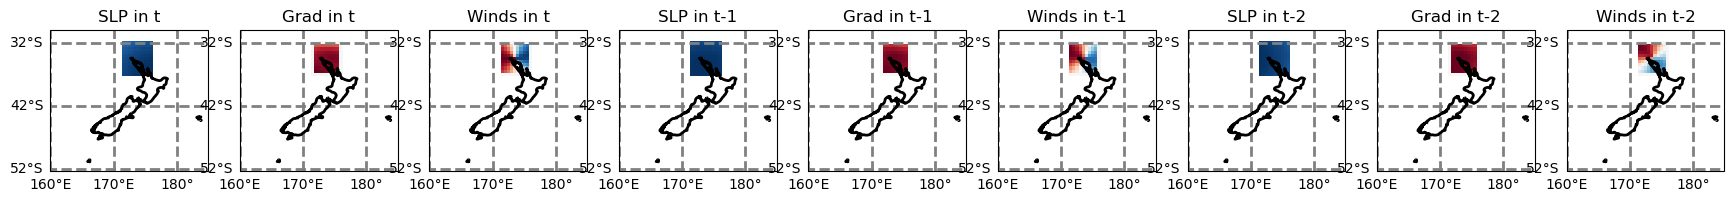

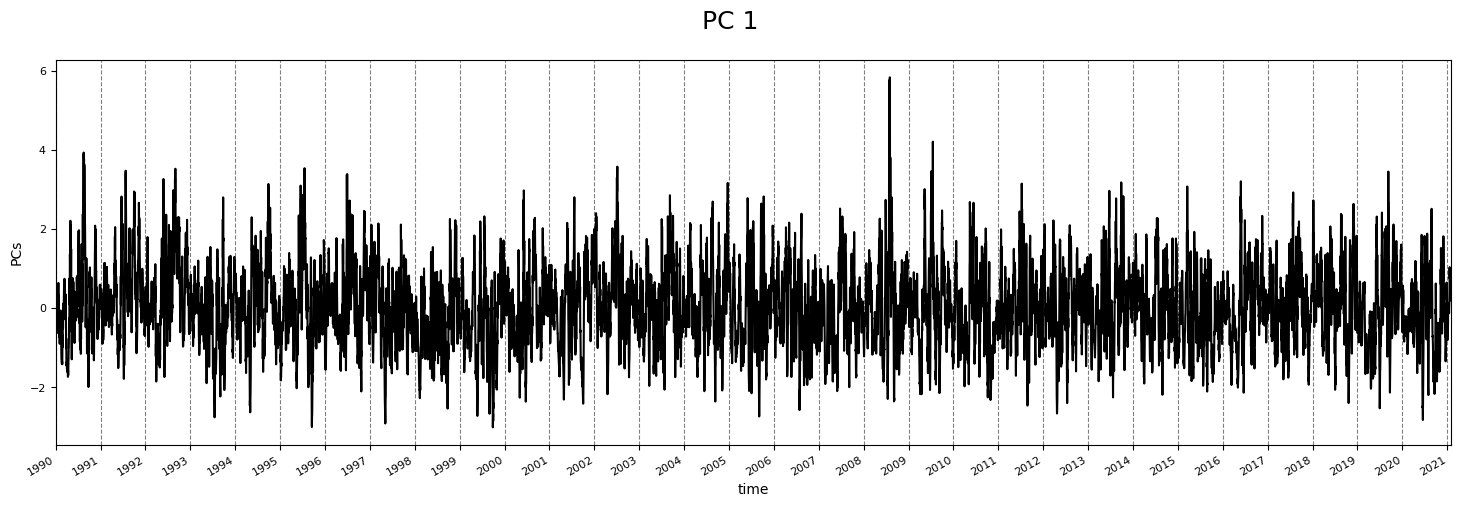

pcs matrix calculation for site / shore 19
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -33.25 -33.56 -33.88 ... -37.31 -37.62 -37.94
  * lon             (lon) float32 170.3 170.6 170.9 171.2 ... 174.4 174.7 175.0
Data variables:
    U_GRD_L103      (time, lat, lon) float32 -7.944 -7.522 ... -1.116 -0.6512
    V_GRD_L103      (time, lat, lon) float32 -0.5016 -0.1978 ... 3.372 2.188
    uw2             (time, lat, lon) float32 63.1 56.59 50.07 ... 1.246 0.424
    vw2             (time, lat, lon) float32 0.2516 0.03914 ... 11.37 4.786
    wind_magnitude  (time, lat, lon) float32 7.959 7.525 7.077 ... 3.552 2.283 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990-0

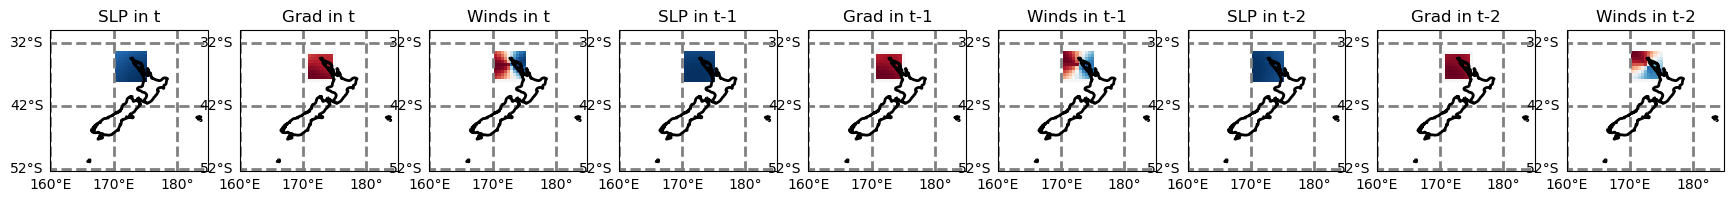

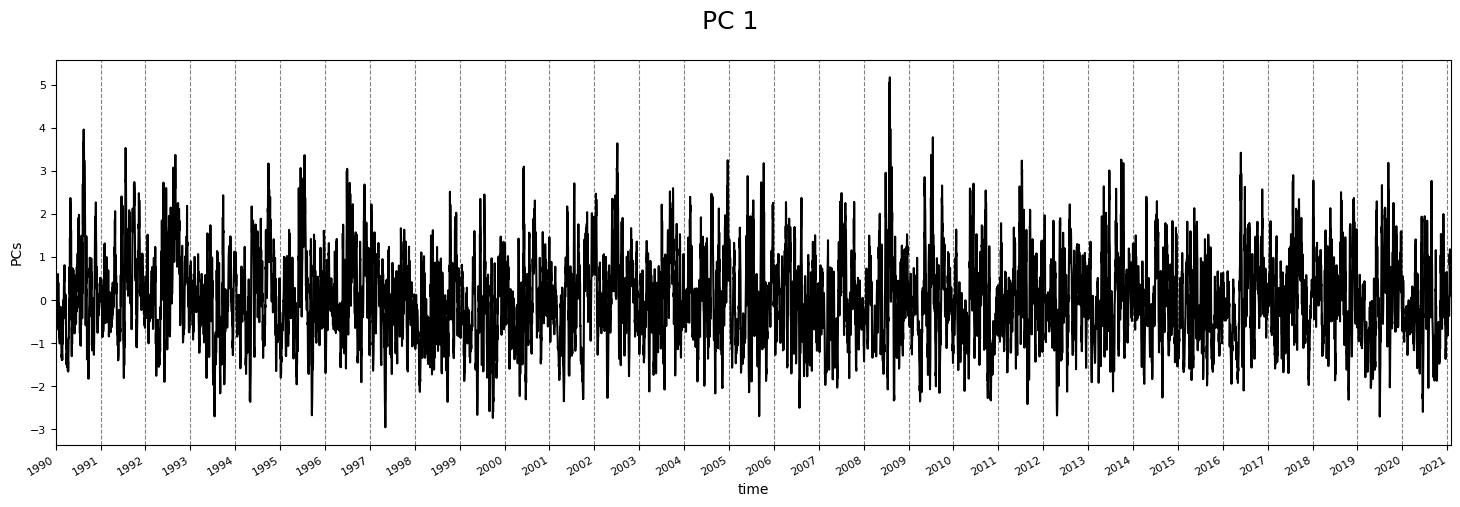

pcs matrix calculation for site / shore 20
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -34.5 -34.81 -35.13 ... -38.56 -38.87 -39.18
  * lon             (lon) float32 171.6 171.9 172.2 172.5 ... 175.6 175.9 176.2
Data variables:
    U_GRD_L103      (time, lat, lon) float32 -1.764 -1.471 ... -0.3078 -0.7109
    V_GRD_L103      (time, lat, lon) float32 -2.778 -2.663 ... 2.953 3.224
    uw2             (time, lat, lon) float32 3.112 2.165 ... 0.09473 0.5053
    vw2             (time, lat, lon) float32 7.717 7.091 5.87 ... 8.719 10.4
    wind_magnitude  (time, lat, lon) float32 3.291 3.042 2.665 ... 2.969 3.302 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1990-01-0

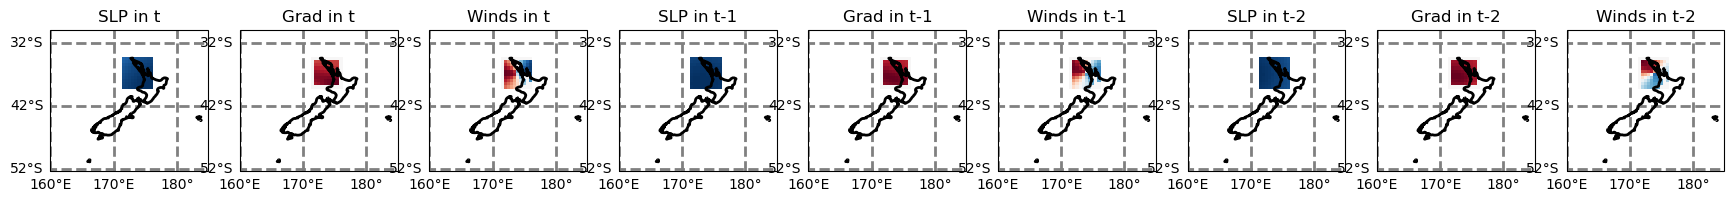

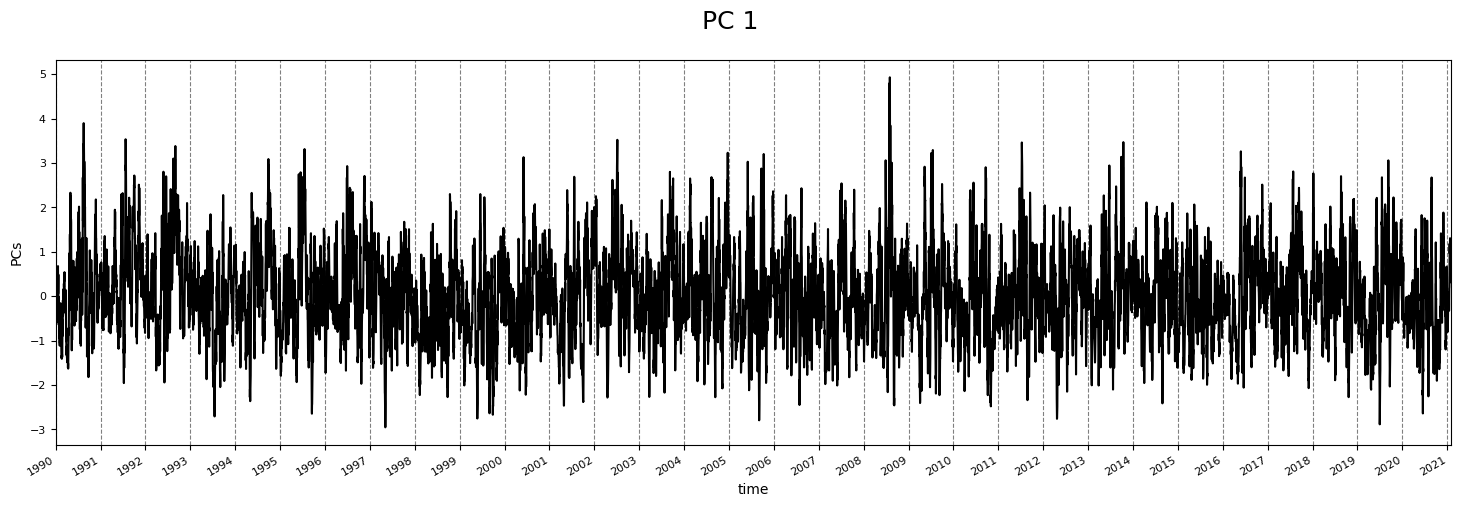

pcs matrix calculation for site / shore 21
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -36.06 -36.37 -36.69 ... -40.12 -40.43 -40.75
  * lon             (lon) float32 172.5 172.8 173.1 173.4 ... 176.6 176.9 177.2
Data variables:
    U_GRD_L103      (time, lat, lon) float32 -3.981 -3.606 -3.18 ... 4.849 5.095
    V_GRD_L103      (time, lat, lon) float32 1.977 2.115 2.313 ... 10.06 10.52
    uw2             (time, lat, lon) float32 15.85 13.01 10.12 ... 23.51 25.96
    vw2             (time, lat, lon) float32 3.91 4.475 5.348 ... 101.3 110.6
    wind_magnitude  (time, lat, lon) float32 4.445 4.181 3.932 ... 11.17 11.68 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns

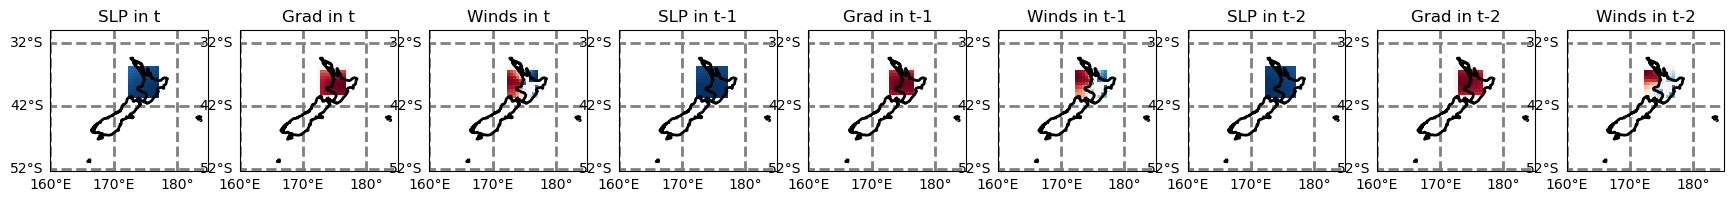

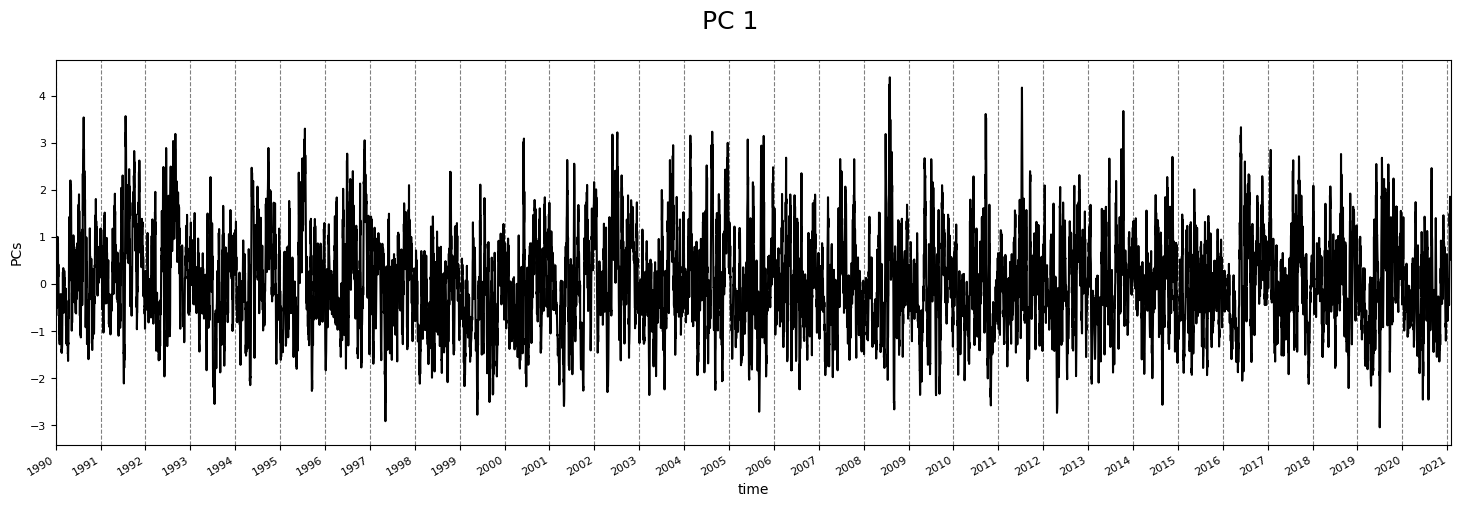

pcs matrix calculation for site / shore 22
 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -41.68 -41.99 -42.31 ... -45.74 -46.05 -46.37
  * lon             (lon) float32 181.2 181.6 181.9 182.2 ... 185.3 185.6 185.9
Data variables:
    U_GRD_L103      (time, lat, lon) float32 0.7058 0.9853 ... -2.043 -2.071
    V_GRD_L103      (time, lat, lon) float32 2.786 2.949 3.04 ... 11.92 11.39
    uw2             (time, lat, lon) float32 0.4982 0.9709 1.789 ... 4.173 4.287
    vw2             (time, lat, lon) float32 7.764 8.697 9.244 ... 142.2 129.7
    wind_magnitude  (time, lat, lon) float32 2.874 3.109 3.321 ... 12.1 11.58 


 lets calculate the PCs... 


 adding the wind to the predictor... 

<xarray.Dataset>
Dimensions:          (lat: 16, lon: 16, time: 11444)
Coordinates:
  * time             (time) datetime64[ns] 1

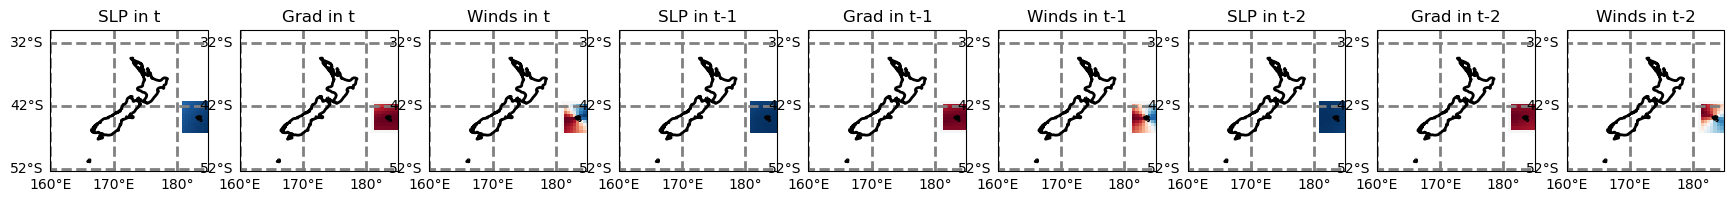

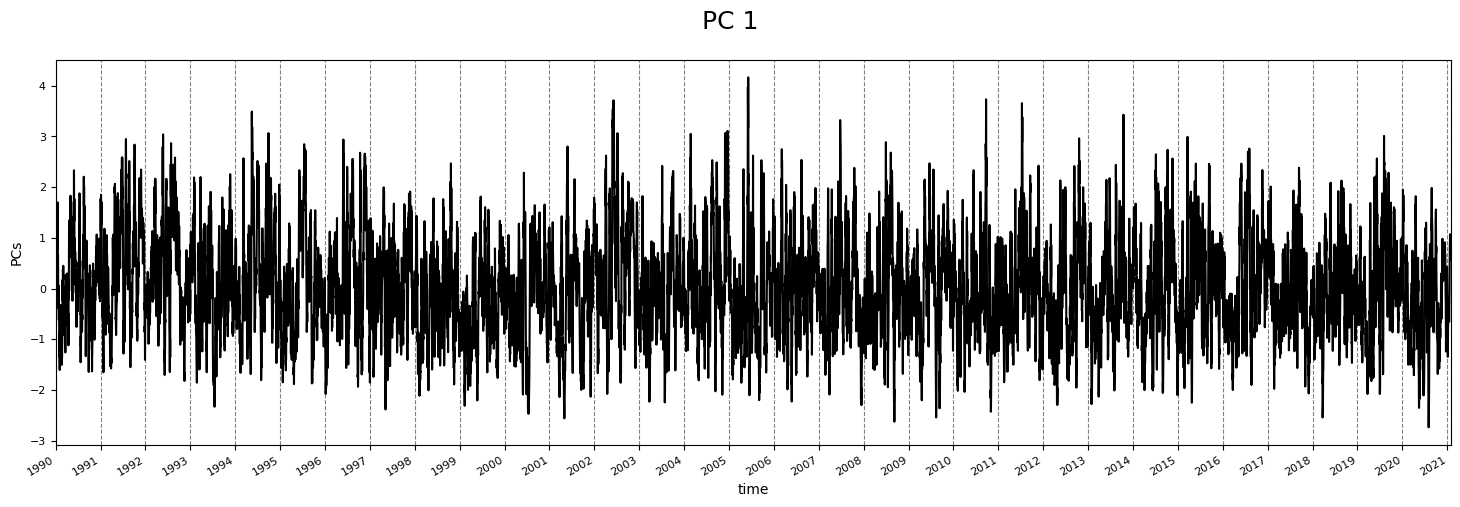

In [3]:
# dict to pca
pca_attrs_default = {
    'pres_vars': ('SLP','longitude','latitude'),
    'calculate_gradient': True,
    'winds': (True,load_cfsr_moana_uhslc.predictor_wind), 
    'wind_vars': ('wind_proj_mask','lon','lat'),
    'time_lapse': 3, # 1 equals to NO time delay,
    'time_resample': '1D', 'region': ('local',(2.5,2.5)),
    'pca_plot': (True,False,1), 'verbose': True,
    'pca_ttls': [
        'SLP in t','Grad in t','Winds in t',
        'SLP in t-1','Grad in t-1','Winds in t-1',
        'SLP in t-2','Grad in t-2','Winds in t-2'
    ], 
    'pca_borders': None
}
sites_to_analyze = np.unique(
    [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
      1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
      1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
    ]
)

# construct the MDA + RBF object
mda_rbf_model = MDA_RBF_Model(
    load_cfsr_moana_uhslc.predictand, # load_cfsr_moana_uhslc.predictand, 
    load_cfsr_moana_uhslc.predictor_slp,
    pca_attrs_default, # all params to calculate the pcs
    model_metrics=default_evaluation_metrics,
    time_resample='1D',
    # -------------------------------------------------------- #
    # set sites_to_analyze to None to shore analysis
    sites_to_analyze=None # list(sites_to_analyze)
    # -------------------------------------------------------- #
)

In [9]:
for i in range(1,len(mda_rbf_model.shore_sites)-1):
    print(np.intersect1d(mda_rbf_model.shore_sites[i],mda_rbf_model.shore_sites[i+1]))
    print(np.intersect1d(mda_rbf_model.shore_sites[i],mda_rbf_model.shore_sites[i-1]))

[]
[]
[]
[]
[100 101 102 103 104 105 106]
[]
[]
[100 101 102 103 104 105 106]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[878 881]
[]
[]
[878 881]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1392 1398 1399 1400 1405 1407 1408 1409 1410 1413 1414 1415 1420 1421]
[]
[]
[1392 1398 1399 1400 1405 1407 1408 1409 1410 1413 1414 1415 1420 1421]
[]
[]
[]
[]


In [5]:
# these are the final sites by shore
np.save('../data/statistics/shore_sites_last.npy',np.array(mda_rbf_model.shore_sites))

In [6]:
# calculate the MDA + RBF adjustments
interpolated_ss_by_rbf = mda_rbf_model.calc_MDA_RBF(
    selected_shores=np.arange(len(mda_rbf_model.shore_sites)), # indexes in python counter
    # len(sites_to_analyze[::8])
    percentage_pcs_ini=[0.92,0.95,0.98], # this is for the SLP
    num_samples_ini=[10,25,50,100,250,500,1000,1500],
    ss_pcs=5, append_extremes=10, try_all=True
    # the ss_pcs parameter is very important, set to 1 when working with single locations
)


 Lets interpolate the SS using all the calculated             pcs (slp + ss) and the MDA+RBF technique!!             This interpolation will be performed in all the locations!! 


 Lets reconstruct the SS for location 1!! 


 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 10 samples!! 

 which means 13 PCs... 


 ------------------------------------------------------------- 



We finally have 20 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.02 | interpolation: 0.29 | sigma: 0.2905
ix_scalar: 1,  optimization: 0.02 | interpolation: 0.20 | sigma: 0.2010
ix_scalar: 2,  optimization: 0.03 | interpolation: 0.25 | sigma: 0.2479
ix_scalar: 3,  optimization: 0.05 | interpolation: 0.24 | sigma: 0.2376
ix_scalar: 4,  optimization: 0.02 | interpolation: 0.30 | sigma: 0.2995

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 10 samples!! 

 which means 17 PCs... 


 ----

ix_scalar: 3,  optimization: 11.58 | interpolation: 0.43 | sigma: 0.4256
ix_scalar: 4,  optimization: 4.74 | interpolation: 0.42 | sigma: 0.4212

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 250 samples!! 

 which means 17 PCs... 


 ------------------------------------------------------------- 



We finally have 260 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 4.98 | interpolation: 0.39 | sigma: 0.3877
ix_scalar: 1,  optimization: 11.89 | interpolation: 0.57 | sigma: 0.5658
ix_scalar: 2,  optimization: 7.36 | interpolation: 0.41 | sigma: 0.4131
ix_scalar: 3,  optimization: 12.65 | interpolation: 0.43 | sigma: 0.4335
ix_scalar: 4,  optimization: 5.02 | interpolation: 0.39 | sigma: 0.3940

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 250 samples!! 

 which means 30 PCs... 


 ------------------------------------------------------------- 



We finally ha

ix_scalar: 0,  optimization: 0.03 | interpolation: 0.32 | sigma: 0.3152
ix_scalar: 1,  optimization: 0.05 | interpolation: 0.29 | sigma: 0.2859
ix_scalar: 2,  optimization: 0.05 | interpolation: 0.27 | sigma: 0.2671
ix_scalar: 3,  optimization: 0.03 | interpolation: 0.27 | sigma: 0.2747
ix_scalar: 4,  optimization: 0.05 | interpolation: 0.26 | sigma: 0.2615

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 25 samples!! 

 which means 13 PCs... 


 ------------------------------------------------------------- 



We finally have 35 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.05 | interpolation: 0.22 | sigma: 0.2207
ix_scalar: 1,  optimization: 0.06 | interpolation: 0.21 | sigma: 0.2131
ix_scalar: 2,  optimization: 0.05 | interpolation: 0.20 | sigma: 0.2047
ix_scalar: 3,  optimization: 0.05 | interpolation: 0.21 | sigma: 0.2138
ix_scalar: 4,  optimization: 0.05 | interpolation: 0.23 | sigma: 0.2298

 ------------

ix_scalar: 1,  optimization: 13.70 | interpolation: 0.50 | sigma: 0.4989
ix_scalar: 2,  optimization: 12.48 | interpolation: 0.47 | sigma: 0.4710
ix_scalar: 3,  optimization: 14.11 | interpolation: 0.57 | sigma: 0.5724
ix_scalar: 4,  optimization: 14.34 | interpolation: 0.49 | sigma: 0.4864

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 500 samples!! 

 which means 17 PCs... 


 ------------------------------------------------------------- 



We finally have 509 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 11.53 | interpolation: 0.55 | sigma: 0.5542
ix_scalar: 1,  optimization: 9.22 | interpolation: 0.50 | sigma: 0.5024
ix_scalar: 2,  optimization: 11.99 | interpolation: 0.50 | sigma: 0.5028
ix_scalar: 3,  optimization: 18.55 | interpolation: 0.54 | sigma: 0.5431
ix_scalar: 4,  optimization: 12.87 | interpolation: 0.53 | sigma: 0.5346

 ------------------------------------------------------------- 


 MDA + RB

ix_scalar: 0,  optimization: 0.09 | interpolation: 0.27 | sigma: 0.2715
ix_scalar: 1,  optimization: 0.14 | interpolation: 0.24 | sigma: 0.2356
ix_scalar: 2,  optimization: 0.10 | interpolation: 0.24 | sigma: 0.2384
ix_scalar: 3,  optimization: 0.07 | interpolation: 0.22 | sigma: 0.2224
ix_scalar: 4,  optimization: 0.14 | interpolation: 0.23 | sigma: 0.2302

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 25 samples!! 

 which means 24 PCs... 


 ------------------------------------------------------------- 



We finally have 34 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.12 | interpolation: 0.28 | sigma: 0.2820
ix_scalar: 1,  optimization: 0.19 | interpolation: 0.35 | sigma: 0.3524
ix_scalar: 2,  optimization: 0.12 | interpolation: 0.34 | sigma: 0.3372
ix_scalar: 3,  optimization: 0.07 | interpolation: 0.26 | sigma: 0.2619
ix_scalar: 4,  optimization: 0.16 | interpolation: 0.28 | sigma: 0.2816

 ------------

ix_scalar: 1,  optimization: 15.05 | interpolation: 0.52 | sigma: 0.5155
ix_scalar: 2,  optimization: 9.12 | interpolation: 0.51 | sigma: 0.5134
ix_scalar: 3,  optimization: 19.60 | interpolation: 0.54 | sigma: 0.5355
ix_scalar: 4,  optimization: 15.08 | interpolation: 0.55 | sigma: 0.5514

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 1000 samples!! 

 which means 11 PCs... 


 ------------------------------------------------------------- 



We finally have 1007 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 74.22 | interpolation: 0.60 | sigma: 0.5982
ix_scalar: 1,  optimization: 31.65 | interpolation: 0.60 | sigma: 0.5987
ix_scalar: 2,  optimization: 40.45 | interpolation: 0.60 | sigma: 0.5973
ix_scalar: 3,  optimization: 116.35 | interpolation: 0.68 | sigma: 0.6822
ix_scalar: 4,  optimization: 43.48 | interpolation: 0.58 | sigma: 0.5768

 ------------------------------------------------------------- 


 MDA +

ix_scalar: 1,  optimization: 0.55 | interpolation: 0.25 | sigma: 0.2528
ix_scalar: 2,  optimization: 0.40 | interpolation: 0.25 | sigma: 0.2485
ix_scalar: 3,  optimization: 0.24 | interpolation: 0.25 | sigma: 0.2511
ix_scalar: 4,  optimization: 0.24 | interpolation: 0.25 | sigma: 0.2457

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 50 samples!! 

 which means 14 PCs... 


 ------------------------------------------------------------- 



We finally have 59 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.26 | interpolation: 0.26 | sigma: 0.2605
ix_scalar: 1,  optimization: 0.30 | interpolation: 0.26 | sigma: 0.2599
ix_scalar: 2,  optimization: 0.36 | interpolation: 0.26 | sigma: 0.2638
ix_scalar: 3,  optimization: 0.21 | interpolation: 0.26 | sigma: 0.2600
ix_scalar: 4,  optimization: 0.43 | interpolation: 0.26 | sigma: 0.2609

 ------------------------------------------------------------- 


 MDA + RBF with 0.9

ix_scalar: 2,  optimization: 37.91 | interpolation: 0.63 | sigma: 0.6338
ix_scalar: 3,  optimization: 47.26 | interpolation: 0.64 | sigma: 0.6380
ix_scalar: 4,  optimization: 34.73 | interpolation: 0.63 | sigma: 0.6262

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 1000 samples!! 

 which means 24 PCs... 


 ------------------------------------------------------------- 



We finally have 1008 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 56.81 | interpolation: 0.74 | sigma: 0.7407
ix_scalar: 1,  optimization: 43.57 | interpolation: 0.74 | sigma: 0.7409
ix_scalar: 2,  optimization: 31.11 | interpolation: 0.75 | sigma: 0.7457
ix_scalar: 3,  optimization: 34.09 | interpolation: 0.75 | sigma: 0.7484
ix_scalar: 4,  optimization: 37.93 | interpolation: 0.76 | sigma: 0.7625

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 1500 samples!! 

 which means 11 PCs... 




ix_scalar: 2,  optimization: 0.68 | interpolation: 0.32 | sigma: 0.3240
ix_scalar: 3,  optimization: 0.77 | interpolation: 0.35 | sigma: 0.3462
ix_scalar: 4,  optimization: 0.54 | interpolation: 0.35 | sigma: 0.3470

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 100 samples!! 

 which means 11 PCs... 


 ------------------------------------------------------------- 



We finally have 108 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.71 | interpolation: 0.34 | sigma: 0.3415
ix_scalar: 1,  optimization: 1.09 | interpolation: 0.36 | sigma: 0.3622
ix_scalar: 2,  optimization: 3.16 | interpolation: 0.36 | sigma: 0.3630
ix_scalar: 3,  optimization: 2.54 | interpolation: 0.38 | sigma: 0.3775
ix_scalar: 4,  optimization: 2.93 | interpolation: 0.38 | sigma: 0.3803

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 100 samples!! 

 which means 12 PCs... 


 ----------



We finally have 1507 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 210.90 | interpolation: 0.95 | sigma: 0.9461
ix_scalar: 1,  optimization: 183.06 | interpolation: 0.76 | sigma: 0.7606
ix_scalar: 2,  optimization: 140.94 | interpolation: 0.77 | sigma: 0.7684
ix_scalar: 3,  optimization: 128.22 | interpolation: 0.78 | sigma: 0.7763
ix_scalar: 4,  optimization: 101.18 | interpolation: 0.79 | sigma: 0.7883

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 1500 samples!! 

 which means 20 PCs... 


 ------------------------------------------------------------- 



We finally have 1507 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 192.51 | interpolation: 0.93 | sigma: 0.9303
ix_scalar: 1,  optimization: 160.89 | interpolation: 0.94 | sigma: 0.9406
ix_scalar: 2,  optimization: 166.85 | interpolation: 0.91 | sigma: 0.9145
ix_scalar: 3,  optimization: 201.49 | interpolation: 0.95 | sigma: 0.9485
ix_sc

ix_scalar: 0,  optimization: 0.65 | interpolation: 0.36 | sigma: 0.3598
ix_scalar: 1,  optimization: 2.34 | interpolation: 0.39 | sigma: 0.3885
ix_scalar: 2,  optimization: 2.97 | interpolation: 0.39 | sigma: 0.3899
ix_scalar: 3,  optimization: 0.83 | interpolation: 0.37 | sigma: 0.3687
ix_scalar: 4,  optimization: 2.16 | interpolation: 0.40 | sigma: 0.3952

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 250 samples!! 

 which means 10 PCs... 


 ------------------------------------------------------------- 



We finally have 260 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 3.54 | interpolation: 0.35 | sigma: 0.3455
ix_scalar: 1,  optimization: 3.76 | interpolation: 0.34 | sigma: 0.3442
ix_scalar: 2,  optimization: 3.46 | interpolation: 0.35 | sigma: 0.3465
ix_scalar: 3,  optimization: 3.72 | interpolation: 0.35 | sigma: 0.3504
ix_scalar: 4,  optimization: 6.10 | interpolation: 0.35 | sigma: 0.3462

 ----------

ix_scalar: 0,  optimization: 0.02 | interpolation: 0.19 | sigma: 0.1941
ix_scalar: 1,  optimization: 0.05 | interpolation: 0.20 | sigma: 0.1961
ix_scalar: 2,  optimization: 0.02 | interpolation: 0.19 | sigma: 0.1880
ix_scalar: 3,  optimization: 0.02 | interpolation: 0.19 | sigma: 0.1877
ix_scalar: 4,  optimization: 0.05 | interpolation: 0.19 | sigma: 0.1900

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 10 samples!! 

 which means 15 PCs... 


 ------------------------------------------------------------- 



We finally have 20 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.02 | interpolation: 0.20 | sigma: 0.1952
ix_scalar: 1,  optimization: 0.05 | interpolation: 0.20 | sigma: 0.2038
ix_scalar: 2,  optimization: 0.04 | interpolation: 0.20 | sigma: 0.2003
ix_scalar: 3,  optimization: 0.04 | interpolation: 0.21 | sigma: 0.2059
ix_scalar: 4,  optimization: 0.05 | interpolation: 0.21 | sigma: 0.2133

 ------------

ix_scalar: 1,  optimization: 9.24 | interpolation: 0.42 | sigma: 0.4174
ix_scalar: 2,  optimization: 3.27 | interpolation: 0.38 | sigma: 0.3820
ix_scalar: 3,  optimization: 4.03 | interpolation: 0.38 | sigma: 0.3810
ix_scalar: 4,  optimization: 8.54 | interpolation: 0.42 | sigma: 0.4223

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 250 samples!! 

 which means 25 PCs... 


 ------------------------------------------------------------- 



We finally have 260 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 3.46 | interpolation: 0.43 | sigma: 0.4328
ix_scalar: 1,  optimization: 4.02 | interpolation: 0.43 | sigma: 0.4266
ix_scalar: 2,  optimization: 8.23 | interpolation: 0.45 | sigma: 0.4520
ix_scalar: 3,  optimization: 3.76 | interpolation: 0.43 | sigma: 0.4320
ix_scalar: 4,  optimization: 4.58 | interpolation: 0.45 | sigma: 0.4521

 ------------------------------------------------------------- 


 MDA + RBF with 0

ix_scalar: 0,  optimization: 0.04 | interpolation: 0.24 | sigma: 0.2361
ix_scalar: 1,  optimization: 0.03 | interpolation: 0.23 | sigma: 0.2343
ix_scalar: 2,  optimization: 0.04 | interpolation: 0.23 | sigma: 0.2335
ix_scalar: 3,  optimization: 0.03 | interpolation: 0.24 | sigma: 0.2396
ix_scalar: 4,  optimization: 0.03 | interpolation: 0.24 | sigma: 0.2414

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 25 samples!! 

 which means 15 PCs... 


 ------------------------------------------------------------- 



We finally have 35 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.05 | interpolation: 0.21 | sigma: 0.2075
ix_scalar: 1,  optimization: 0.13 | interpolation: 0.21 | sigma: 0.2144
ix_scalar: 2,  optimization: 0.06 | interpolation: 0.21 | sigma: 0.2063
ix_scalar: 3,  optimization: 0.06 | interpolation: 0.21 | sigma: 0.2104
ix_scalar: 4,  optimization: 0.06 | interpolation: 0.21 | sigma: 0.2064

 ------------

ix_scalar: 1,  optimization: 12.18 | interpolation: 0.46 | sigma: 0.4625
ix_scalar: 2,  optimization: 18.77 | interpolation: 0.49 | sigma: 0.4934
ix_scalar: 3,  optimization: 11.37 | interpolation: 0.46 | sigma: 0.4637
ix_scalar: 4,  optimization: 9.05 | interpolation: 0.48 | sigma: 0.4809

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 500 samples!! 

 which means 19 PCs... 


 ------------------------------------------------------------- 



We finally have 510 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 13.65 | interpolation: 0.49 | sigma: 0.4888
ix_scalar: 1,  optimization: 8.95 | interpolation: 0.49 | sigma: 0.4916
ix_scalar: 2,  optimization: 10.53 | interpolation: 0.50 | sigma: 0.4952
ix_scalar: 3,  optimization: 11.45 | interpolation: 0.48 | sigma: 0.4836
ix_scalar: 4,  optimization: 9.08 | interpolation: 0.49 | sigma: 0.4896

 ------------------------------------------------------------- 


 MDA + RBF 

ix_scalar: 0,  optimization: 0.04 | interpolation: 0.23 | sigma: 0.2269
ix_scalar: 1,  optimization: 0.05 | interpolation: 0.22 | sigma: 0.2239
ix_scalar: 2,  optimization: 0.14 | interpolation: 0.23 | sigma: 0.2307
ix_scalar: 3,  optimization: 0.04 | interpolation: 0.23 | sigma: 0.2251
ix_scalar: 4,  optimization: 0.06 | interpolation: 0.22 | sigma: 0.2242

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 25 samples!! 

 which means 35 PCs... 


 ------------------------------------------------------------- 



We finally have 34 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.09 | interpolation: 0.26 | sigma: 0.2575
ix_scalar: 1,  optimization: 0.10 | interpolation: 0.26 | sigma: 0.2639
ix_scalar: 2,  optimization: 0.10 | interpolation: 0.26 | sigma: 0.2586
ix_scalar: 3,  optimization: 0.08 | interpolation: 0.26 | sigma: 0.2551
ix_scalar: 4,  optimization: 0.11 | interpolation: 0.26 | sigma: 0.2581

 ------------

ix_scalar: 1,  optimization: 11.51 | interpolation: 0.62 | sigma: 0.6189
ix_scalar: 2,  optimization: 27.41 | interpolation: 0.64 | sigma: 0.6398
ix_scalar: 3,  optimization: 9.24 | interpolation: 0.62 | sigma: 0.6211
ix_scalar: 4,  optimization: 26.70 | interpolation: 0.63 | sigma: 0.6275

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 1000 samples!! 

 which means 15 PCs... 


 ------------------------------------------------------------- 



We finally have 1007 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 84.26 | interpolation: 0.64 | sigma: 0.6407
ix_scalar: 1,  optimization: 37.63 | interpolation: 0.67 | sigma: 0.6654
ix_scalar: 2,  optimization: 34.88 | interpolation: 0.65 | sigma: 0.6457
ix_scalar: 3,  optimization: 46.04 | interpolation: 0.64 | sigma: 0.6386
ix_scalar: 4,  optimization: 55.85 | interpolation: 0.64 | sigma: 0.6380

 ------------------------------------------------------------- 


 MDA + 

ix_scalar: 1,  optimization: 0.81 | interpolation: 0.27 | sigma: 0.2740
ix_scalar: 2,  optimization: 0.30 | interpolation: 0.26 | sigma: 0.2636
ix_scalar: 3,  optimization: 0.30 | interpolation: 0.27 | sigma: 0.2659
ix_scalar: 4,  optimization: 0.33 | interpolation: 0.29 | sigma: 0.2878

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 50 samples!! 

 which means 20 PCs... 


 ------------------------------------------------------------- 



We finally have 60 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.80 | interpolation: 0.36 | sigma: 0.3613
ix_scalar: 1,  optimization: 0.28 | interpolation: 0.33 | sigma: 0.3318
ix_scalar: 2,  optimization: 0.32 | interpolation: 0.33 | sigma: 0.3306
ix_scalar: 3,  optimization: 0.88 | interpolation: 0.36 | sigma: 0.3617
ix_scalar: 4,  optimization: 0.86 | interpolation: 0.39 | sigma: 0.3896

 ------------------------------------------------------------- 


 MDA + RBF with 0.9

ix_scalar: 2,  optimization: 64.32 | interpolation: 0.70 | sigma: 0.6981
ix_scalar: 3,  optimization: 34.65 | interpolation: 0.71 | sigma: 0.7145
ix_scalar: 4,  optimization: 31.72 | interpolation: 0.71 | sigma: 0.7081

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 1000 samples!! 

 which means 35 PCs... 


 ------------------------------------------------------------- 



We finally have 1010 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 114.72 | interpolation: 0.98 | sigma: 0.9845
ix_scalar: 1,  optimization: 74.02 | interpolation: 0.98 | sigma: 0.9756
ix_scalar: 2,  optimization: 50.24 | interpolation: 0.92 | sigma: 0.9155
ix_scalar: 3,  optimization: 43.60 | interpolation: 0.92 | sigma: 0.9174
ix_scalar: 4,  optimization: 40.89 | interpolation: 0.95 | sigma: 0.9463

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 1500 samples!! 

 which means 14 PCs... 



ix_scalar: 2,  optimization: 0.60 | interpolation: 0.39 | sigma: 0.3887
ix_scalar: 3,  optimization: 0.80 | interpolation: 0.41 | sigma: 0.4101
ix_scalar: 4,  optimization: 0.41 | interpolation: 0.39 | sigma: 0.3892

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 100 samples!! 

 which means 13 PCs... 


 ------------------------------------------------------------- 



We finally have 110 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.75 | interpolation: 0.38 | sigma: 0.3797
ix_scalar: 1,  optimization: 2.00 | interpolation: 0.37 | sigma: 0.3744
ix_scalar: 2,  optimization: 3.01 | interpolation: 0.43 | sigma: 0.4264
ix_scalar: 3,  optimization: 1.18 | interpolation: 0.41 | sigma: 0.4082
ix_scalar: 4,  optimization: 1.29 | interpolation: 0.38 | sigma: 0.3845

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 100 samples!! 

 which means 18 PCs... 


 ----------

ix_scalar: 1,  optimization: 92.96 | interpolation: 0.89 | sigma: 0.8889
ix_scalar: 2,  optimization: 91.57 | interpolation: 0.93 | sigma: 0.9317
ix_scalar: 3,  optimization: 237.10 | interpolation: 0.98 | sigma: 0.9780
ix_scalar: 4,  optimization: 232.93 | interpolation: 0.95 | sigma: 0.9498

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 1500 samples!! 

 which means 33 PCs... 


 ------------------------------------------------------------- 



We finally have 1506 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 224.83 | interpolation: 1.19 | sigma: 1.1949
ix_scalar: 1,  optimization: 207.79 | interpolation: 1.21 | sigma: 1.2129
ix_scalar: 2,  optimization: 104.63 | interpolation: 1.19 | sigma: 1.1855
ix_scalar: 3,  optimization: 210.49 | interpolation: 1.18 | sigma: 1.1840
ix_scalar: 4,  optimization: 121.27 | interpolation: 1.14 | sigma: 1.1356

 Lets reconstruct the SS for location 12!! 


 ------------------

ix_scalar: 1,  optimization: 1.15 | interpolation: 0.43 | sigma: 0.4311
ix_scalar: 2,  optimization: 3.04 | interpolation: 0.43 | sigma: 0.4339
ix_scalar: 3,  optimization: 0.98 | interpolation: 0.43 | sigma: 0.4291
ix_scalar: 4,  optimization: 1.10 | interpolation: 0.42 | sigma: 0.4249

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 250 samples!! 

 which means 13 PCs... 


 ------------------------------------------------------------- 



We finally have 259 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 2.91 | interpolation: 0.36 | sigma: 0.3629
ix_scalar: 1,  optimization: 4.64 | interpolation: 0.37 | sigma: 0.3679
ix_scalar: 2,  optimization: 4.70 | interpolation: 0.36 | sigma: 0.3629
ix_scalar: 3,  optimization: 2.79 | interpolation: 0.37 | sigma: 0.3727
ix_scalar: 4,  optimization: 3.32 | interpolation: 0.37 | sigma: 0.3698

 ------------------------------------------------------------- 


 MDA + RBF with 0

ix_scalar: 0,  optimization: 0.03 | interpolation: 0.19 | sigma: 0.1892
ix_scalar: 1,  optimization: 0.02 | interpolation: 0.19 | sigma: 0.1862
ix_scalar: 2,  optimization: 0.02 | interpolation: 0.19 | sigma: 0.1883
ix_scalar: 3,  optimization: 0.02 | interpolation: 0.19 | sigma: 0.1872
ix_scalar: 4,  optimization: 0.03 | interpolation: 0.19 | sigma: 0.1867

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 10 samples!! 

 which means 16 PCs... 


 ------------------------------------------------------------- 



We finally have 20 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.05 | interpolation: 0.20 | sigma: 0.1982
ix_scalar: 1,  optimization: 0.04 | interpolation: 0.19 | sigma: 0.1929
ix_scalar: 2,  optimization: 0.05 | interpolation: 0.19 | sigma: 0.1923
ix_scalar: 3,  optimization: 0.03 | interpolation: 0.20 | sigma: 0.1994
ix_scalar: 4,  optimization: 0.03 | interpolation: 0.19 | sigma: 0.1927

 ------------

ix_scalar: 1,  optimization: 5.32 | interpolation: 0.38 | sigma: 0.3752
ix_scalar: 2,  optimization: 3.53 | interpolation: 0.43 | sigma: 0.4344
ix_scalar: 3,  optimization: 9.43 | interpolation: 0.42 | sigma: 0.4162
ix_scalar: 4,  optimization: 3.04 | interpolation: 0.37 | sigma: 0.3708

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 250 samples!! 

 which means 28 PCs... 


 ------------------------------------------------------------- 



We finally have 259 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 9.47 | interpolation: 0.45 | sigma: 0.4502
ix_scalar: 1,  optimization: 2.96 | interpolation: 0.45 | sigma: 0.4464
ix_scalar: 2,  optimization: 3.46 | interpolation: 0.44 | sigma: 0.4385
ix_scalar: 3,  optimization: 2.94 | interpolation: 0.45 | sigma: 0.4483
ix_scalar: 4,  optimization: 3.20 | interpolation: 0.44 | sigma: 0.4406

 ------------------------------------------------------------- 


 MDA + RBF with 0

ix_scalar: 0,  optimization: 0.03 | interpolation: 0.23 | sigma: 0.2261
ix_scalar: 1,  optimization: 0.03 | interpolation: 0.23 | sigma: 0.2298
ix_scalar: 2,  optimization: 0.03 | interpolation: 0.23 | sigma: 0.2289
ix_scalar: 3,  optimization: 0.02 | interpolation: 0.23 | sigma: 0.2278
ix_scalar: 4,  optimization: 0.02 | interpolation: 0.23 | sigma: 0.2303

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 25 samples!! 

 which means 14 PCs... 


 ------------------------------------------------------------- 



We finally have 33 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.05 | interpolation: 0.19 | sigma: 0.1931
ix_scalar: 1,  optimization: 0.03 | interpolation: 0.19 | sigma: 0.1929
ix_scalar: 2,  optimization: 0.05 | interpolation: 0.19 | sigma: 0.1934
ix_scalar: 3,  optimization: 0.06 | interpolation: 0.19 | sigma: 0.1939
ix_scalar: 4,  optimization: 0.08 | interpolation: 0.22 | sigma: 0.2152

 ------------

ix_scalar: 1,  optimization: 10.17 | interpolation: 0.45 | sigma: 0.4548
ix_scalar: 2,  optimization: 8.89 | interpolation: 0.44 | sigma: 0.4404
ix_scalar: 3,  optimization: 9.65 | interpolation: 0.44 | sigma: 0.4425
ix_scalar: 4,  optimization: 8.18 | interpolation: 0.45 | sigma: 0.4478

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 500 samples!! 

 which means 18 PCs... 


 ------------------------------------------------------------- 



We finally have 508 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 13.05 | interpolation: 0.47 | sigma: 0.4733
ix_scalar: 1,  optimization: 9.75 | interpolation: 0.48 | sigma: 0.4787
ix_scalar: 2,  optimization: 9.13 | interpolation: 0.49 | sigma: 0.4861
ix_scalar: 3,  optimization: 11.00 | interpolation: 0.48 | sigma: 0.4837
ix_scalar: 4,  optimization: 8.21 | interpolation: 0.48 | sigma: 0.4812

 ------------------------------------------------------------- 


 MDA + RBF wit

ix_scalar: 1,  optimization: 0.04 | interpolation: 0.20 | sigma: 0.2006
ix_scalar: 2,  optimization: 0.04 | interpolation: 0.21 | sigma: 0.2092
ix_scalar: 3,  optimization: 0.06 | interpolation: 0.20 | sigma: 0.2035
ix_scalar: 4,  optimization: 0.07 | interpolation: 0.21 | sigma: 0.2101

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 25 samples!! 

 which means 24 PCs... 


 ------------------------------------------------------------- 



We finally have 33 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.14 | interpolation: 0.24 | sigma: 0.2416
ix_scalar: 1,  optimization: 0.10 | interpolation: 0.24 | sigma: 0.2435
ix_scalar: 2,  optimization: 0.11 | interpolation: 0.23 | sigma: 0.2336
ix_scalar: 3,  optimization: 0.12 | interpolation: 0.24 | sigma: 0.2416
ix_scalar: 4,  optimization: 0.12 | interpolation: 0.24 | sigma: 0.2367

 ------------------------------------------------------------- 


 MDA + RBF with 0.9

ix_scalar: 2,  optimization: 9.10 | interpolation: 0.52 | sigma: 0.5222
ix_scalar: 3,  optimization: 11.97 | interpolation: 0.58 | sigma: 0.5799
ix_scalar: 4,  optimization: 10.04 | interpolation: 0.53 | sigma: 0.5301

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 1000 samples!! 

 which means 12 PCs... 


 ------------------------------------------------------------- 



We finally have 1006 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 79.74 | interpolation: 0.72 | sigma: 0.7159
ix_scalar: 1,  optimization: 47.16 | interpolation: 0.61 | sigma: 0.6112
ix_scalar: 2,  optimization: 40.76 | interpolation: 0.58 | sigma: 0.5821
ix_scalar: 3,  optimization: 133.25 | interpolation: 0.68 | sigma: 0.6841
ix_scalar: 4,  optimization: 51.91 | interpolation: 0.60 | sigma: 0.5959

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 1000 samples!! 

 which means 15 PCs... 




ix_scalar: 2,  optimization: 0.22 | interpolation: 0.27 | sigma: 0.2684
ix_scalar: 3,  optimization: 0.26 | interpolation: 0.27 | sigma: 0.2671
ix_scalar: 4,  optimization: 0.27 | interpolation: 0.29 | sigma: 0.2888

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 50 samples!! 

 which means 19 PCs... 


 ------------------------------------------------------------- 



We finally have 59 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.23 | interpolation: 0.28 | sigma: 0.2825
ix_scalar: 1,  optimization: 0.36 | interpolation: 0.28 | sigma: 0.2816
ix_scalar: 2,  optimization: 0.23 | interpolation: 0.28 | sigma: 0.2843
ix_scalar: 3,  optimization: 0.32 | interpolation: 0.29 | sigma: 0.2894
ix_scalar: 4,  optimization: 0.25 | interpolation: 0.28 | sigma: 0.2844

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 50 samples!! 

 which means 33 PCs... 


 -------------

ix_scalar: 3,  optimization: 102.40 | interpolation: 0.78 | sigma: 0.7803
ix_scalar: 4,  optimization: 37.14 | interpolation: 0.69 | sigma: 0.6862

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 1000 samples!! 

 which means 33 PCs... 


 ------------------------------------------------------------- 



We finally have 1009 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 89.50 | interpolation: 0.85 | sigma: 0.8472
ix_scalar: 1,  optimization: 37.72 | interpolation: 0.88 | sigma: 0.8849
ix_scalar: 2,  optimization: 45.51 | interpolation: 0.86 | sigma: 0.8576
ix_scalar: 3,  optimization: 44.28 | interpolation: 0.86 | sigma: 0.8569
ix_scalar: 4,  optimization: 31.51 | interpolation: 0.84 | sigma: 0.8414

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 1500 samples!! 

 which means 14 PCs... 


 ------------------------------------------------------------- 



We fi

ix_scalar: 3,  optimization: 0.37 | interpolation: 0.36 | sigma: 0.3555
ix_scalar: 4,  optimization: 0.75 | interpolation: 0.38 | sigma: 0.3821

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 100 samples!! 

 which means 12 PCs... 


 ------------------------------------------------------------- 



We finally have 110 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.75 | interpolation: 0.34 | sigma: 0.3415
ix_scalar: 1,  optimization: 1.40 | interpolation: 0.35 | sigma: 0.3525
ix_scalar: 2,  optimization: 1.29 | interpolation: 0.36 | sigma: 0.3634
ix_scalar: 3,  optimization: 0.88 | interpolation: 0.35 | sigma: 0.3501
ix_scalar: 4,  optimization: 1.18 | interpolation: 0.35 | sigma: 0.3507

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 100 samples!! 

 which means 16 PCs... 


 ------------------------------------------------------------- 



We finally have 

ix_scalar: 3,  optimization: 162.83 | interpolation: 0.76 | sigma: 0.7608
ix_scalar: 4,  optimization: 205.13 | interpolation: 0.76 | sigma: 0.7608

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 1500 samples!! 

 which means 16 PCs... 


 ------------------------------------------------------------- 



We finally have 1508 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 81.17 | interpolation: 0.79 | sigma: 0.7939
ix_scalar: 1,  optimization: 91.16 | interpolation: 0.79 | sigma: 0.7868
ix_scalar: 2,  optimization: 98.70 | interpolation: 0.81 | sigma: 0.8053
ix_scalar: 3,  optimization: 173.76 | interpolation: 0.83 | sigma: 0.8271
ix_scalar: 4,  optimization: 176.74 | interpolation: 0.80 | sigma: 0.7966

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 1500 samples!! 

 which means 27 PCs... 


 ------------------------------------------------------------- 



We

ix_scalar: 0,  optimization: 1.13 | interpolation: 0.39 | sigma: 0.3932
ix_scalar: 1,  optimization: 0.78 | interpolation: 0.39 | sigma: 0.3890
ix_scalar: 2,  optimization: 1.50 | interpolation: 0.40 | sigma: 0.3992
ix_scalar: 3,  optimization: 1.51 | interpolation: 0.40 | sigma: 0.3982
ix_scalar: 4,  optimization: 0.80 | interpolation: 0.39 | sigma: 0.3888

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 250 samples!! 

 which means 11 PCs... 


 ------------------------------------------------------------- 



We finally have 259 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 8.84 | interpolation: 0.39 | sigma: 0.3889
ix_scalar: 1,  optimization: 10.54 | interpolation: 0.39 | sigma: 0.3903
ix_scalar: 2,  optimization: 5.00 | interpolation: 0.36 | sigma: 0.3566
ix_scalar: 3,  optimization: 3.44 | interpolation: 0.35 | sigma: 0.3540
ix_scalar: 4,  optimization: 3.78 | interpolation: 0.37 | sigma: 0.3727

 ---------

ix_scalar: 4,  optimization: 0.02 | interpolation: 0.19 | sigma: 0.1898

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 10 samples!! 

 which means 14 PCs... 


 ------------------------------------------------------------- 



We finally have 20 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.02 | interpolation: 0.20 | sigma: 0.1954
ix_scalar: 1,  optimization: 0.05 | interpolation: 0.20 | sigma: 0.2015
ix_scalar: 2,  optimization: 0.02 | interpolation: 0.19 | sigma: 0.1932
ix_scalar: 3,  optimization: 0.02 | interpolation: 0.19 | sigma: 0.1925
ix_scalar: 4,  optimization: 0.02 | interpolation: 0.20 | sigma: 0.1973

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 10 samples!! 

 which means 24 PCs... 


 ------------------------------------------------------------- 



We finally have 20 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.04 | 

ix_scalar: 0,  optimization: 2.63 | interpolation: 0.41 | sigma: 0.4126
ix_scalar: 1,  optimization: 4.15 | interpolation: 0.42 | sigma: 0.4153
ix_scalar: 2,  optimization: 3.25 | interpolation: 0.42 | sigma: 0.4170
ix_scalar: 3,  optimization: 8.93 | interpolation: 0.44 | sigma: 0.4383
ix_scalar: 4,  optimization: 2.99 | interpolation: 0.41 | sigma: 0.4145

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 500 samples!! 

 which means 11 PCs... 


 ------------------------------------------------------------- 



We finally have 509 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 8.50 | interpolation: 0.44 | sigma: 0.4370
ix_scalar: 1,  optimization: 10.77 | interpolation: 0.43 | sigma: 0.4343
ix_scalar: 2,  optimization: 11.68 | interpolation: 0.43 | sigma: 0.4275
ix_scalar: 3,  optimization: 9.58 | interpolation: 0.43 | sigma: 0.4327
ix_scalar: 4,  optimization: 9.44 | interpolation: 0.43 | sigma: 0.4325

 --------

ix_scalar: 0,  optimization: 0.04 | interpolation: 0.19 | sigma: 0.1890
ix_scalar: 1,  optimization: 0.05 | interpolation: 0.19 | sigma: 0.1885
ix_scalar: 2,  optimization: 0.04 | interpolation: 0.20 | sigma: 0.1987
ix_scalar: 3,  optimization: 0.04 | interpolation: 0.19 | sigma: 0.1891
ix_scalar: 4,  optimization: 0.05 | interpolation: 0.19 | sigma: 0.1905

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 25 samples!! 

 which means 15 PCs... 


 ------------------------------------------------------------- 



We finally have 33 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.04 | interpolation: 0.20 | sigma: 0.1999
ix_scalar: 1,  optimization: 0.04 | interpolation: 0.20 | sigma: 0.2038
ix_scalar: 2,  optimization: 0.04 | interpolation: 0.20 | sigma: 0.2009
ix_scalar: 3,  optimization: 0.04 | interpolation: 0.20 | sigma: 0.2021
ix_scalar: 4,  optimization: 0.04 | interpolation: 0.20 | sigma: 0.2050

 ------------

ix_scalar: 3,  optimization: 11.60 | interpolation: 0.46 | sigma: 0.4649
ix_scalar: 4,  optimization: 8.96 | interpolation: 0.46 | sigma: 0.4641

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 500 samples!! 

 which means 29 PCs... 


 ------------------------------------------------------------- 



We finally have 508 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 14.51 | interpolation: 0.56 | sigma: 0.5630
ix_scalar: 1,  optimization: 7.43 | interpolation: 0.58 | sigma: 0.5835
ix_scalar: 2,  optimization: 16.39 | interpolation: 0.55 | sigma: 0.5541
ix_scalar: 3,  optimization: 7.41 | interpolation: 0.56 | sigma: 0.5570
ix_scalar: 4,  optimization: 9.83 | interpolation: 0.55 | sigma: 0.5538

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 1000 samples!! 

 which means 11 PCs... 


 ------------------------------------------------------------- 



We finally h

ix_scalar: 3,  optimization: 0.11 | interpolation: 0.29 | sigma: 0.2915
ix_scalar: 4,  optimization: 0.08 | interpolation: 0.29 | sigma: 0.2931

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 50 samples!! 

 which means 13 PCs... 


 ------------------------------------------------------------- 



We finally have 57 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.29 | interpolation: 0.28 | sigma: 0.2849
ix_scalar: 1,  optimization: 0.75 | interpolation: 0.33 | sigma: 0.3339
ix_scalar: 2,  optimization: 0.32 | interpolation: 0.31 | sigma: 0.3131
ix_scalar: 3,  optimization: 0.36 | interpolation: 0.31 | sigma: 0.3108
ix_scalar: 4,  optimization: 0.27 | interpolation: 0.29 | sigma: 0.2929

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 50 samples!! 

 which means 19 PCs... 


 ------------------------------------------------------------- 



We finally have 57 

ix_scalar: 4,  optimization: 95.19 | interpolation: 0.65 | sigma: 0.6480

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 1000 samples!! 

 which means 19 PCs... 


 ------------------------------------------------------------- 



We finally have 1006 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 53.88 | interpolation: 0.72 | sigma: 0.7184
ix_scalar: 1,  optimization: 69.76 | interpolation: 0.71 | sigma: 0.7120
ix_scalar: 2,  optimization: 91.10 | interpolation: 1.18 | sigma: 1.1833
ix_scalar: 3,  optimization: 78.41 | interpolation: 0.70 | sigma: 0.7008
ix_scalar: 4,  optimization: 42.58 | interpolation: 0.72 | sigma: 0.7192

 ------------------------------------------------------------- 


 MDA + RBF with 0.98 per of pcs and 1000 samples!! 

 which means 33 PCs... 


 ------------------------------------------------------------- 



We finally have 1006 points to interpolate with RBF!! 


ix_scalar: 0,  optimiz

ix_scalar: 0,  optimization: 0.40 | interpolation: 0.28 | sigma: 0.2824
ix_scalar: 1,  optimization: 0.50 | interpolation: 0.29 | sigma: 0.2897
ix_scalar: 2,  optimization: 0.76 | interpolation: 0.29 | sigma: 0.2941
ix_scalar: 3,  optimization: 0.85 | interpolation: 0.32 | sigma: 0.3195
ix_scalar: 4,  optimization: 0.79 | interpolation: 0.36 | sigma: 0.3619

 ------------------------------------------------------------- 


 MDA + RBF with 0.92 per of pcs and 100 samples!! 

 which means 11 PCs... 


 ------------------------------------------------------------- 



We finally have 110 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 0.78 | interpolation: 0.35 | sigma: 0.3460
ix_scalar: 1,  optimization: 2.86 | interpolation: 0.37 | sigma: 0.3653
ix_scalar: 2,  optimization: 1.17 | interpolation: 0.36 | sigma: 0.3590
ix_scalar: 3,  optimization: 1.08 | interpolation: 0.35 | sigma: 0.3469
ix_scalar: 4,  optimization: 1.17 | interpolation: 0.35 | sigma: 0.3466

 ----------

ix_scalar: 0,  optimization: 190.27 | interpolation: 0.91 | sigma: 0.9118
ix_scalar: 1,  optimization: 165.30 | interpolation: 0.81 | sigma: 0.8126
ix_scalar: 2,  optimization: 437.92 | interpolation: 1.02 | sigma: 1.0195
ix_scalar: 3,  optimization: 255.04 | interpolation: 0.81 | sigma: 0.8136
ix_scalar: 4,  optimization: 300.54 | interpolation: 0.96 | sigma: 0.9596

 ------------------------------------------------------------- 


 MDA + RBF with 0.95 per of pcs and 1500 samples!! 

 which means 13 PCs... 


 ------------------------------------------------------------- 



We finally have 1510 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 164.82 | interpolation: 0.93 | sigma: 0.9281
ix_scalar: 1,  optimization: 129.99 | interpolation: 0.91 | sigma: 0.9118
ix_scalar: 2,  optimization: 303.56 | interpolation: 0.97 | sigma: 0.9686
ix_scalar: 3,  optimization: 264.97 | interpolation: 0.91 | sigma: 0.9072
ix_scalar: 4,  optimization: 235.37 | interpolation: 0.95 | sigm

```{warning}
Run the CELL below to run all the combinations, but be careful with the time it might take. Moreover, if the num_samples_ini parameter is too big, the searching of the optimal sigma in the RBF funtion might not converge!!
```

In [7]:
interpolated_ss_by_rbf.to_netcdf(
    '../data/statistics/experiments/experiment_mdarbf_shores_1D_local_winds_grad_25_10_1500.nc')

No handles with labels found to put in legend.


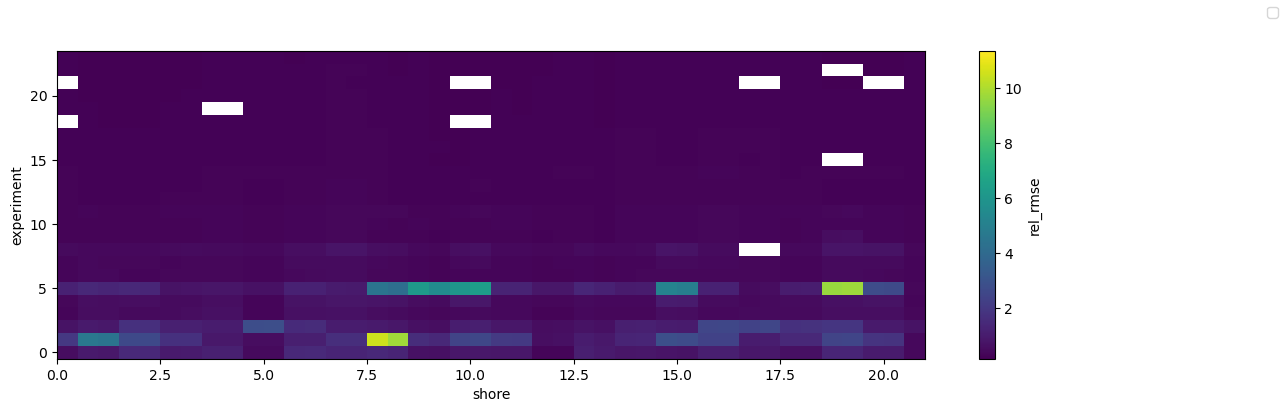

No handles with labels found to put in legend.


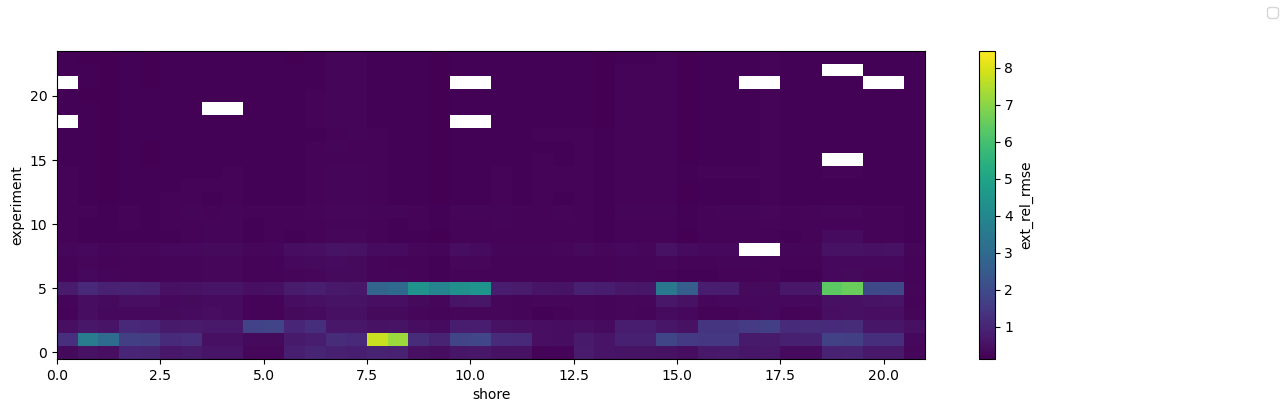

No handles with labels found to put in legend.


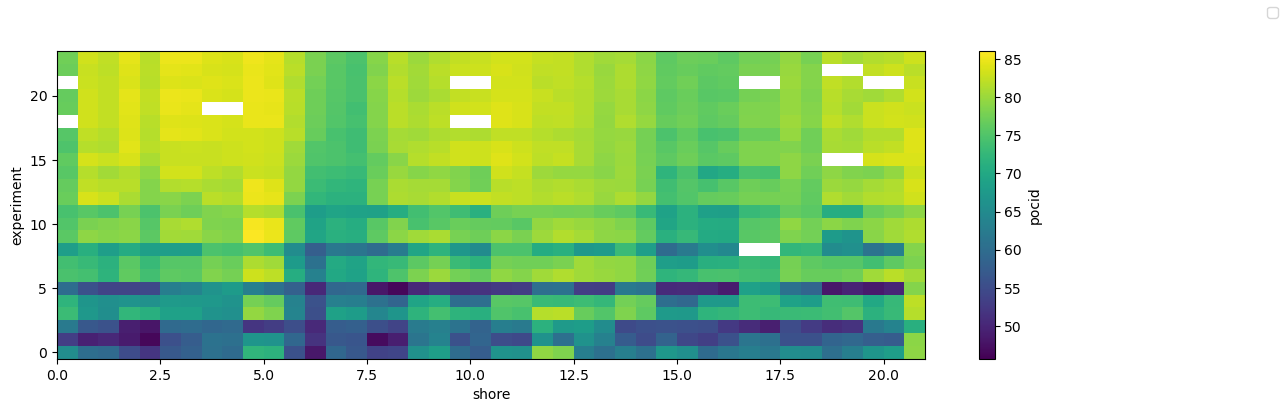

No handles with labels found to put in legend.


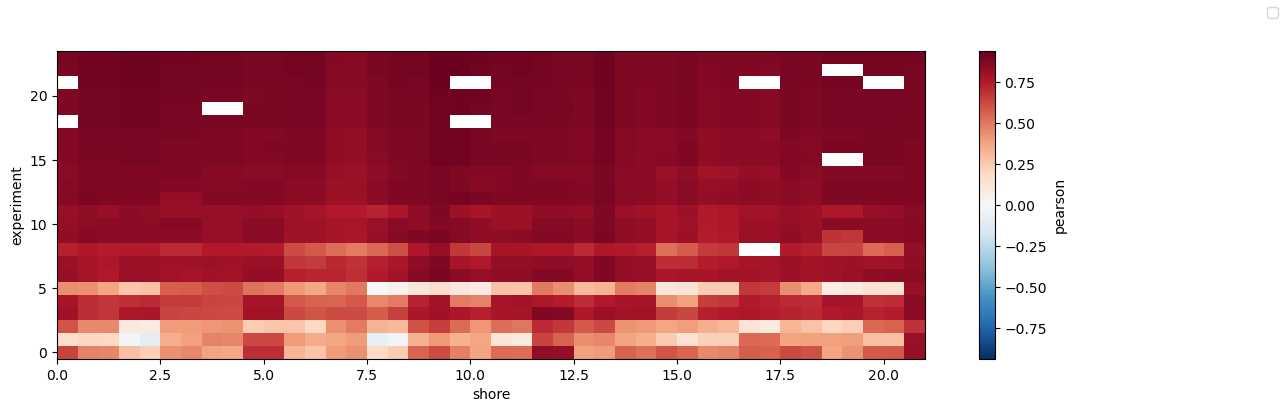

No handles with labels found to put in legend.


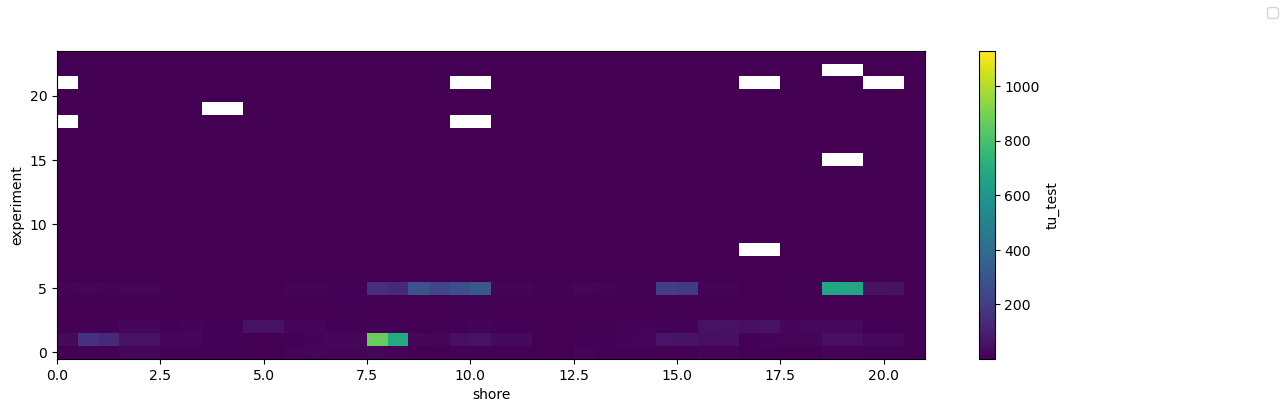

In [8]:
for label in ['rel_rmse','ext_rel_rmse','pocid','pearson','tu_test']:
    fig, ax = plt.subplots(figsize=(14,4))
    interpolated_ss_by_rbf[label].plot(label=label,ax=ax)
    fig.legend()
    plt.show()